In [1]:
import os
import numpy as np
from astropy.io import fits
from linetools.spectra.xspectrum1d import XSpectrum1D
from scipy.signal import find_peaks, savgol_filter
from scipy.optimize import curve_fit
from astropy.stats import sigma_clip
from tqdm import tqdm

# Debugging
import pdb

# Matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams["font.family"] = "serif"
rcParams["font.serif"] = "Times New Roman"
%matplotlib inline
rcParams['text.usetex'] = True
rcParams['text.latex.preamble'] = [r'\usepackage{amsmath} \usepackage{bm} \usepackage{physics}']
%config InlineBackend.figure_format = 'retina' # For high quality figures

In [2]:
data_folder = "../data-2019-09-25-shane-joey-alex-arcelia"

In [3]:
OVERWRITE = True

In [4]:
# Constants
KAST_RED_PS  = 0.43   # arcseconds/pixel
H_ALPHA_REST = 6562.8 # Angstroms
HUBBLE_CONST = 69.8   # km/s/Mpc
C            = 3e5    # km/s

In [5]:
# Helper functions
def calc_redshift(obs, rest):
    return (obs - rest) / rest

def calc_velocity(redshift):
    return redshift * C # km/s

def calc_distance(velocity):
    return velocity / HUBBLE_CONST # Mpc

# Load the wavelength solution

In [6]:
wl = np.load(os.path.join(data_folder, 'wl_solution/wl.npy'))

## Load the UGC11876 data

In [6]:
ugc11876, header_ugc11876 = fits.getdata(os.path.join(data_folder, 'masters/ugc11876_master.fits'), header=True)

In [33]:
# Bracket H_alpha and convert wavelength to column index in the ugc11876 image
blue_wl  = 6645.
red_wl   = 6658.5

blue_ind = np.argwhere(np.isclose(wl, blue_wl * np.ones(len(wl)), rtol=1e-4))[0][0]
red_ind  = np.argwhere(np.isclose(wl, red_wl * np.ones(len(wl)), rtol=1e-4))[0][0]

# Slice the relevant region of the data so that it's easier to access
wl_zoomed       = wl[blue_ind:red_ind + 1]
ugc11876_zoomed = ugc11876[blue_ind:red_ind+1, :]

assert wl_zoomed.shape[0] == ugc11876_zoomed.shape[0], "Dimensions not equal"

## Fit gaussians to the $H_\alpha$ to find the centroids of the line in each pixel

In [34]:
def gaussian(x, a, mu, sigma, cont):
    '''
    Used for scipy.optimize.curve_fit
    '''
    return a * np.sqrt(1/(2 * sigma**2)) * np.exp( -0.5 * ((x - mu) / sigma)**2) + cont

In [51]:
def fit_centroids(x, y_image, good_pixel_start, good_pixel_end, show_plot=False):
    '''
    Try to fit a Gaussian to each H_alpha line in each pixel.
    
    Returns: (ndarray) 
        First column is the wavelength fit for the center of the line.
        Second column is the pixel value from the original science frame on the CCD.
    '''
    
    centroids = np.zeros((y_image.shape[1], 2))
    
    for pixel in range(good_pixels_start, good_pixels_end):
    
        y = y_image[:, pixel]

        # Parameter initial guesses
        cont = np.median(y)
        a    = np.max(y) - cont
        mu   = 6650. # Better way to do this?
        std  = np.std(y)
        
        # Smooth the data before trying to fit
        window_len = 3
        deg = 2
        y = savgol_filter(y, window_len, deg)
        
        try:
            popt, pcov = curve_fit(gaussian, x, y, p0=[a, mu, std, cont])
        except:
            print('Fit not achieved for pixel {}'.format(pixel))
            continue

        a_fit, mu_fit, sigma_fit, cont = popt
        centroids[pixel, 0] = mu_fit
        centroids[pixel, 1] = pixel
        
        if show_plot:
            fig, ax = plt.subplots()
            ax.plot(x, y, color='blue')
            ax.plot(x, gaussian(x, a_fit, mu_fit, sigma_fit, cont), color='red')
            ax.text(6645.6, 800, 'pixel = {}'.format(pixel))
            plt.show()
    
    # Don't include centroids that were not able to be fit
    return centroids[centroids[:, 0] > 0.]

## Run fitting procedure on the good spatial pixel data

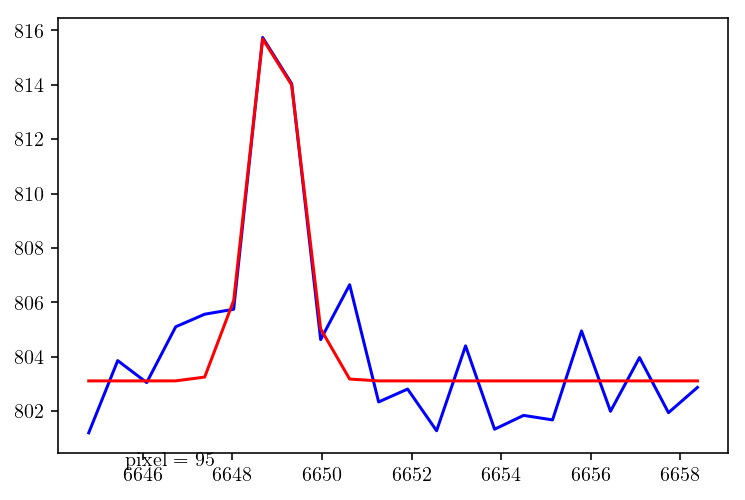

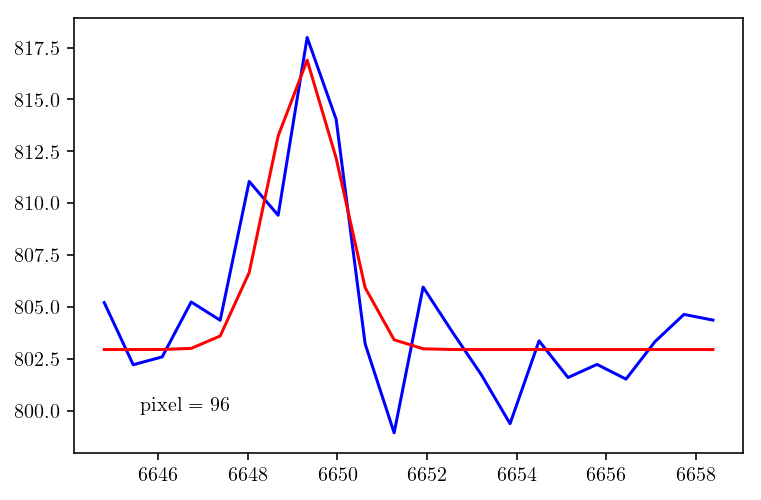

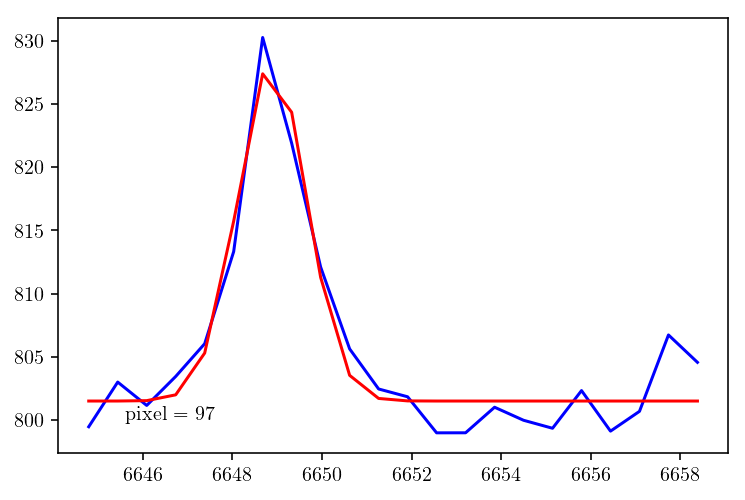

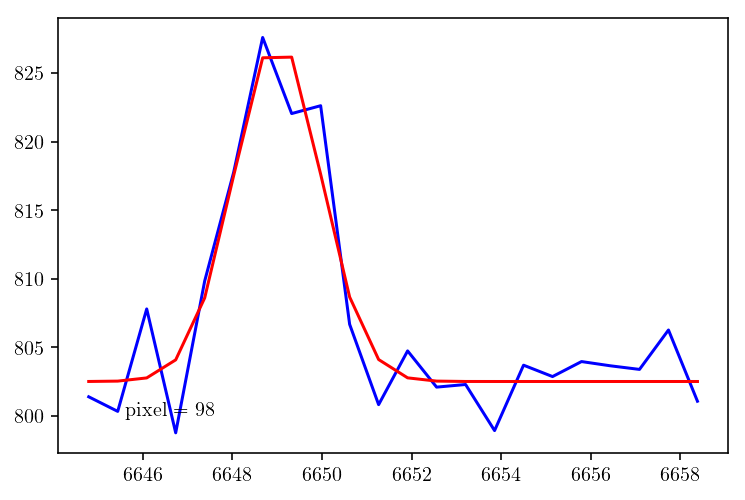

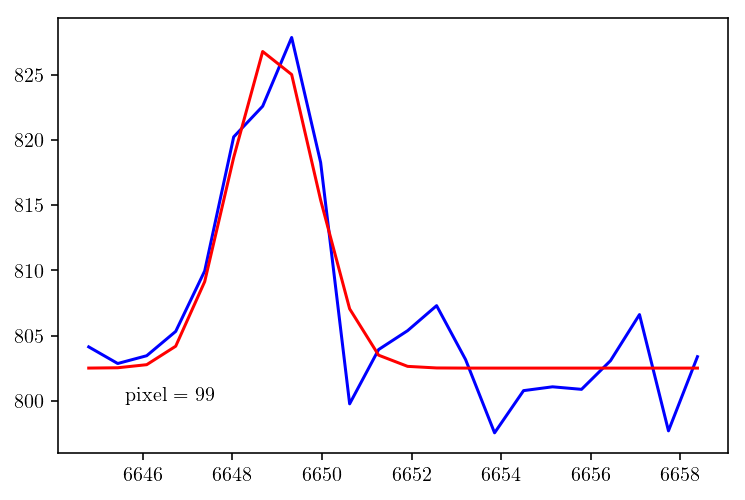

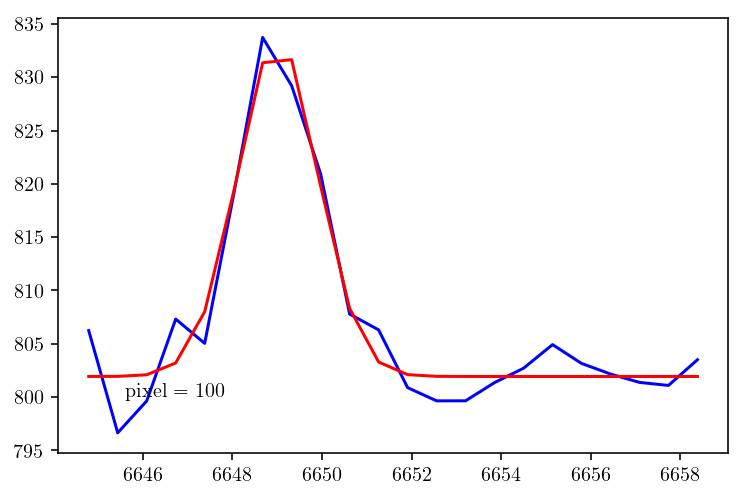

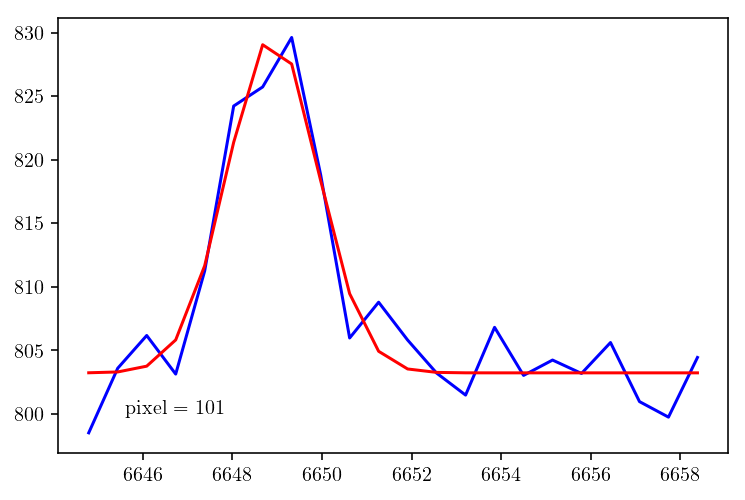

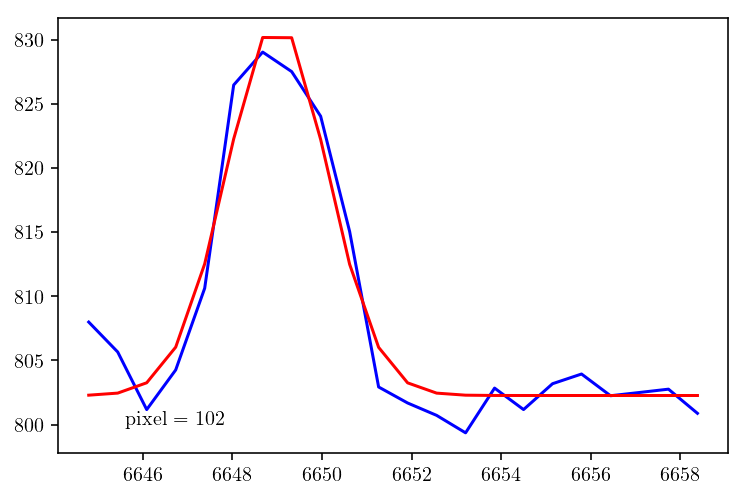

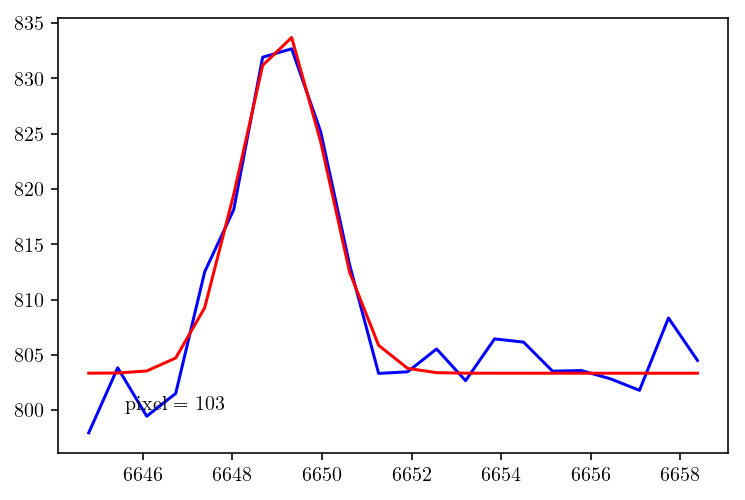

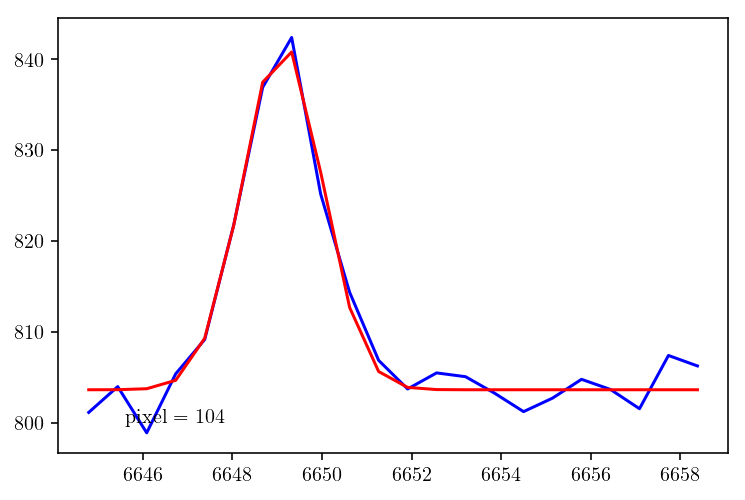

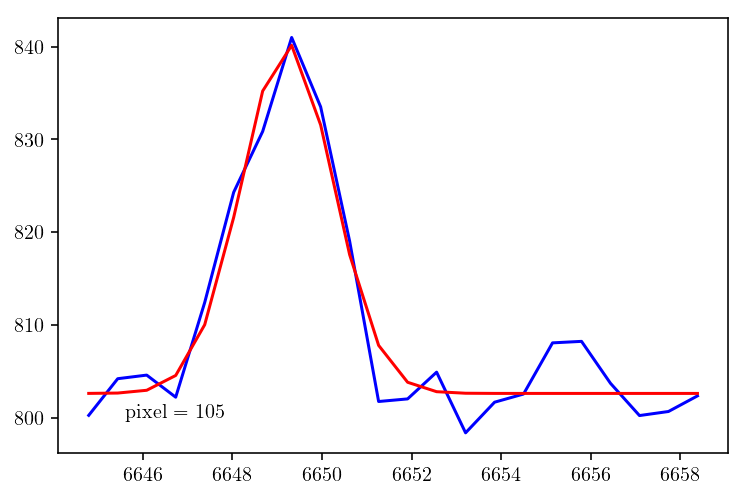

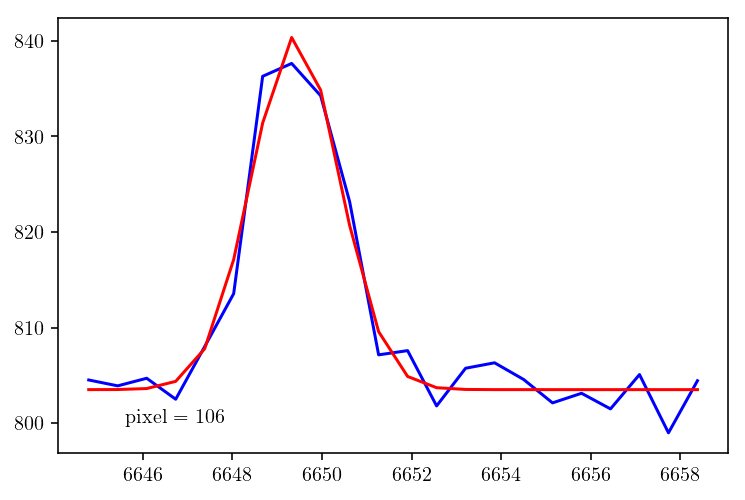

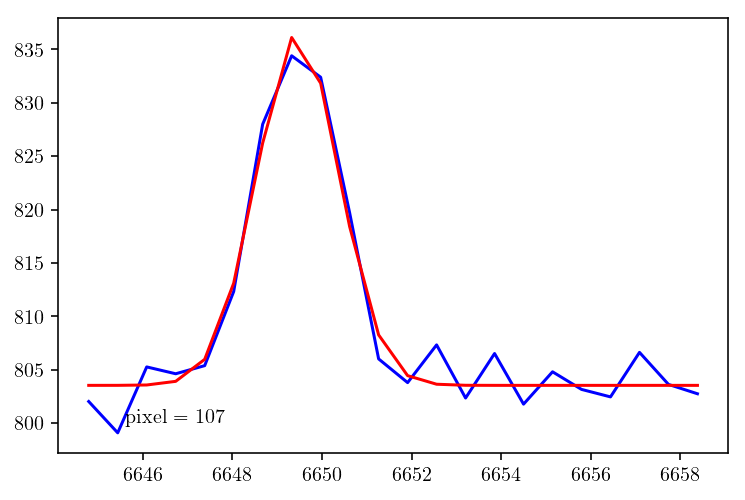

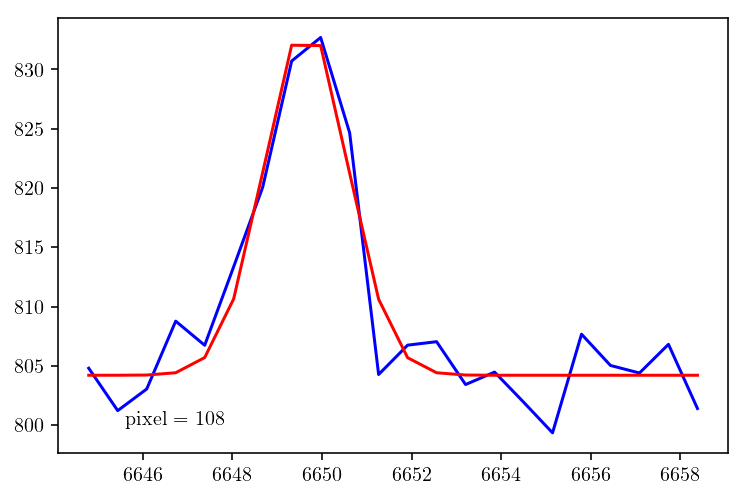

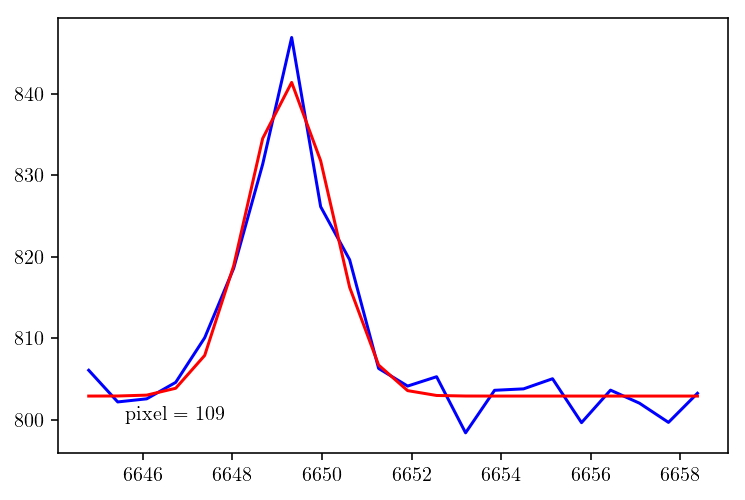

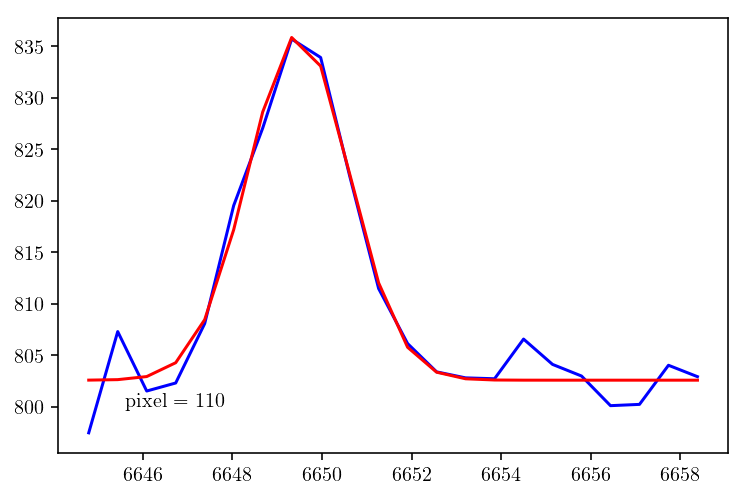

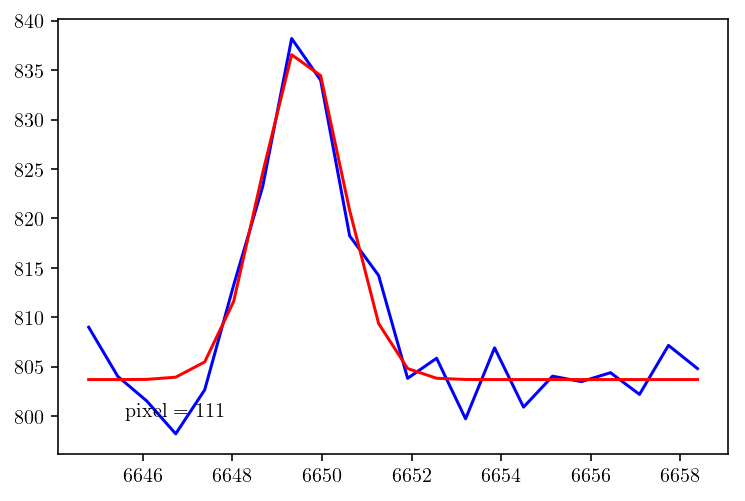

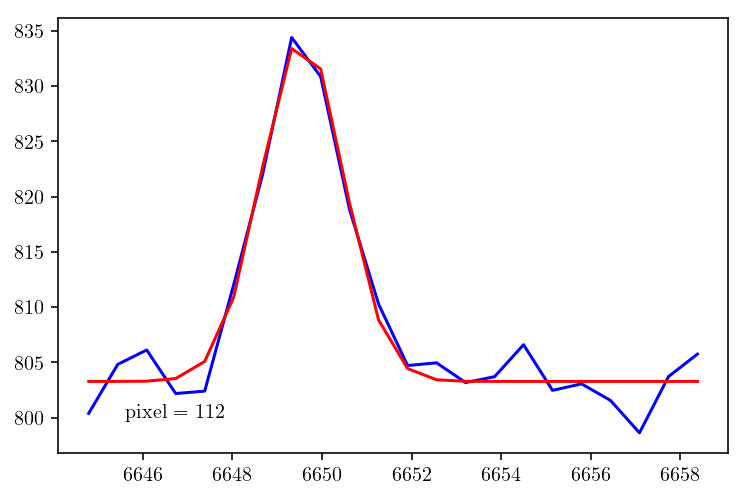

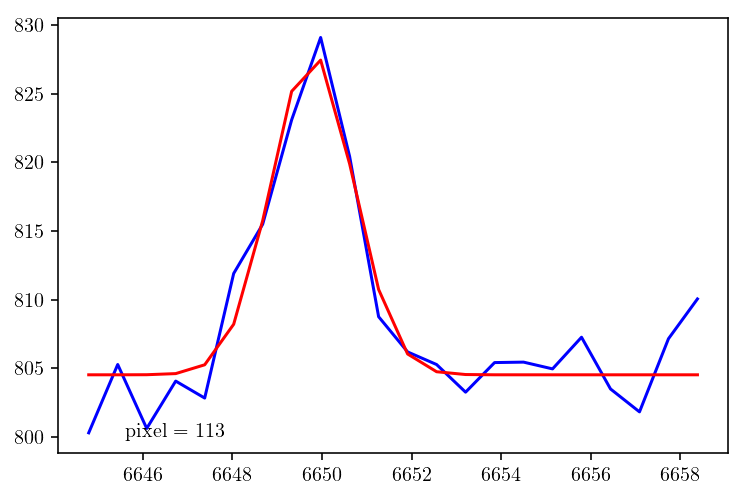

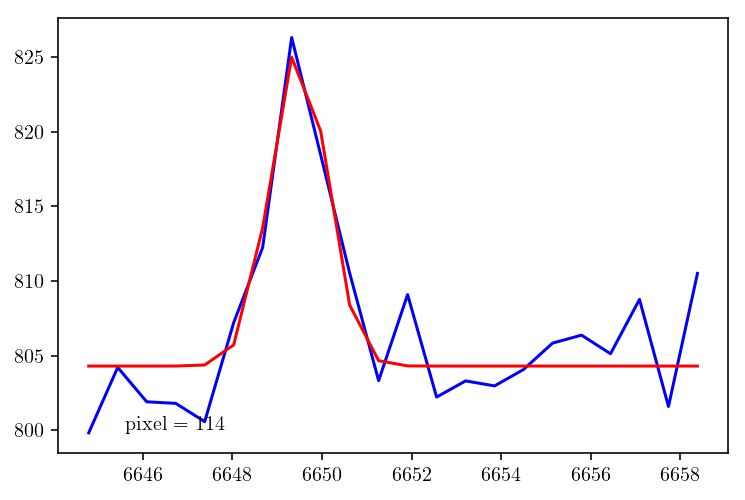

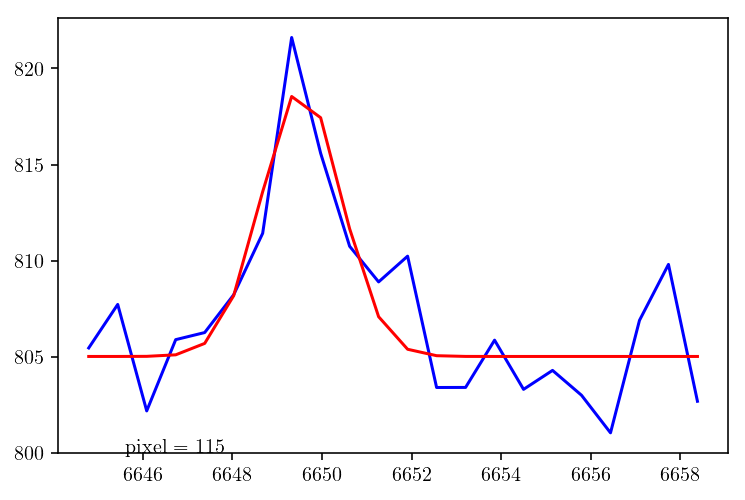

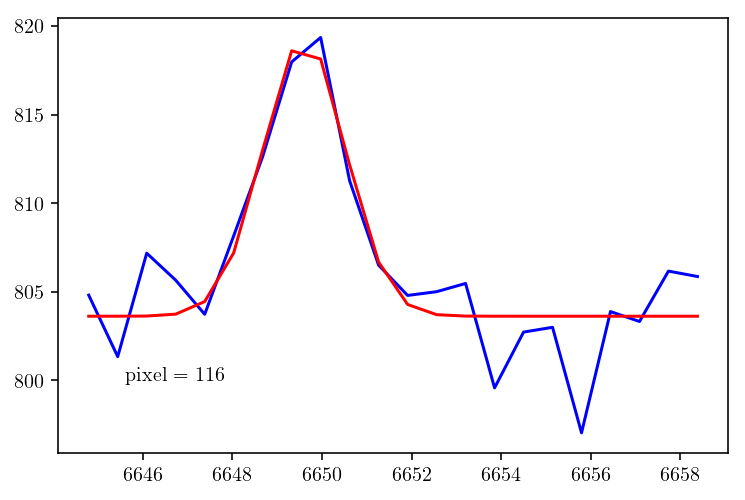

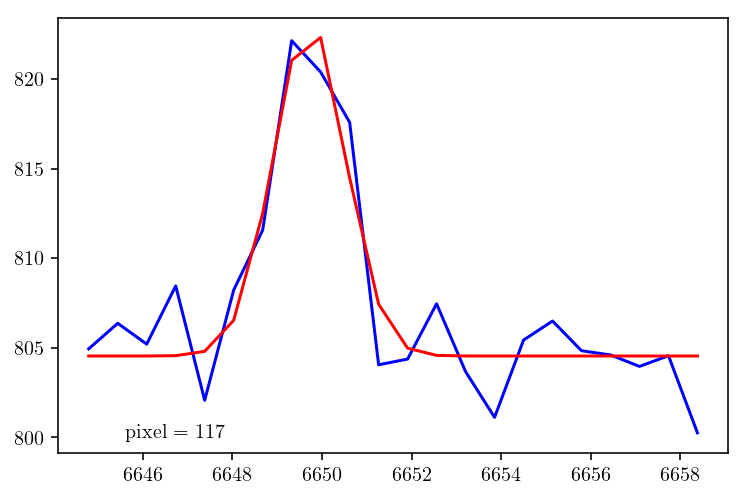

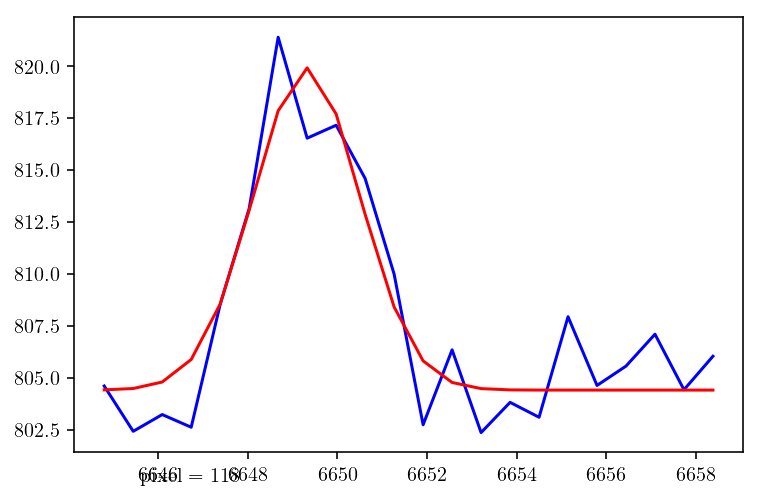

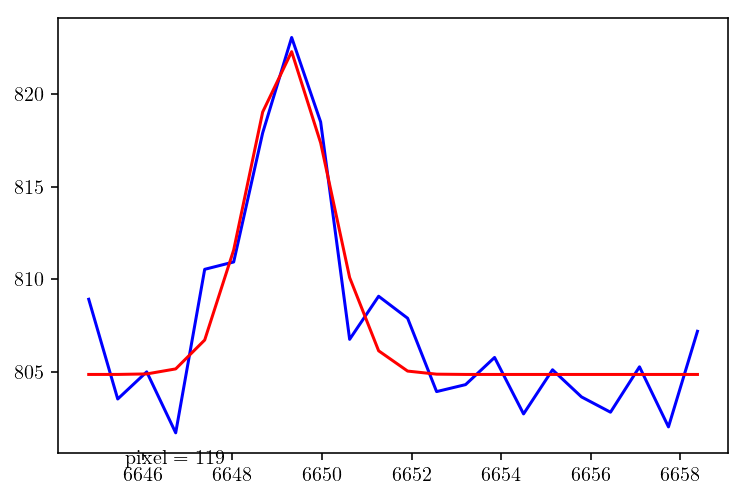

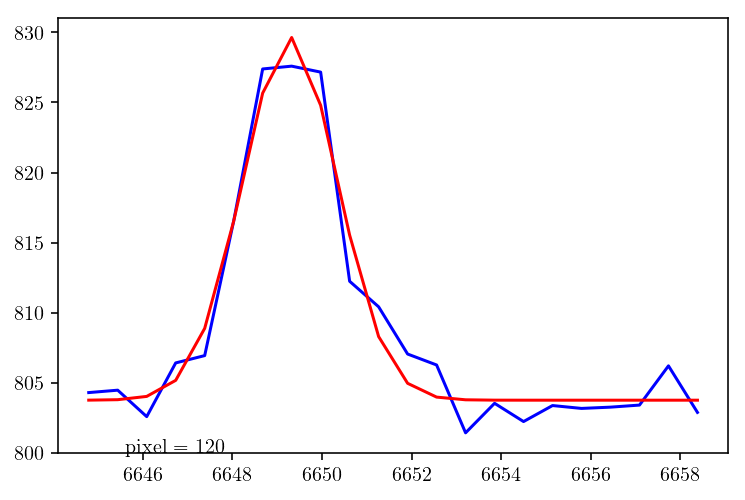

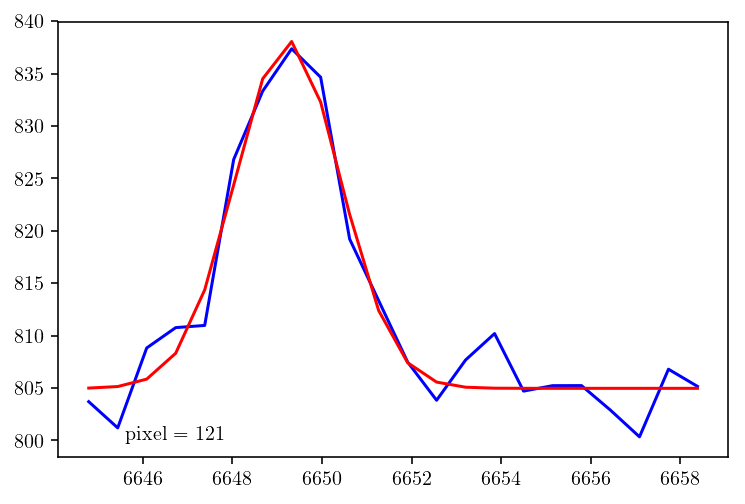

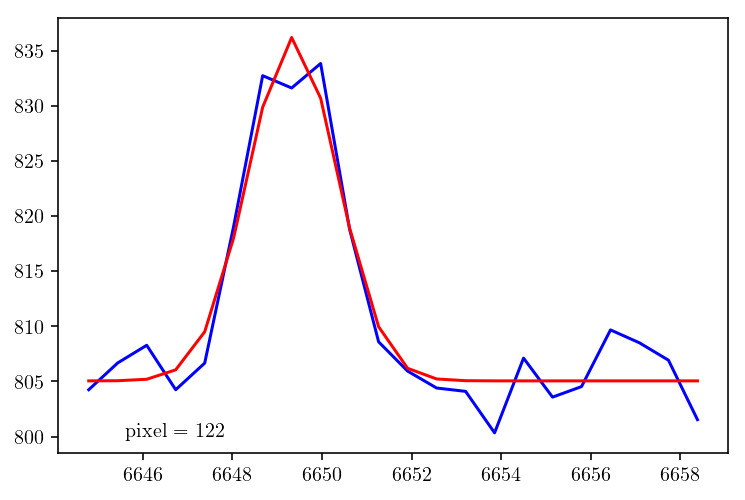

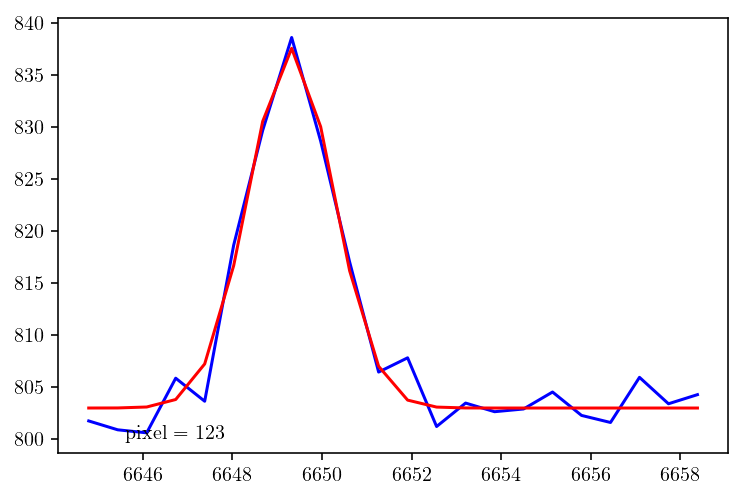

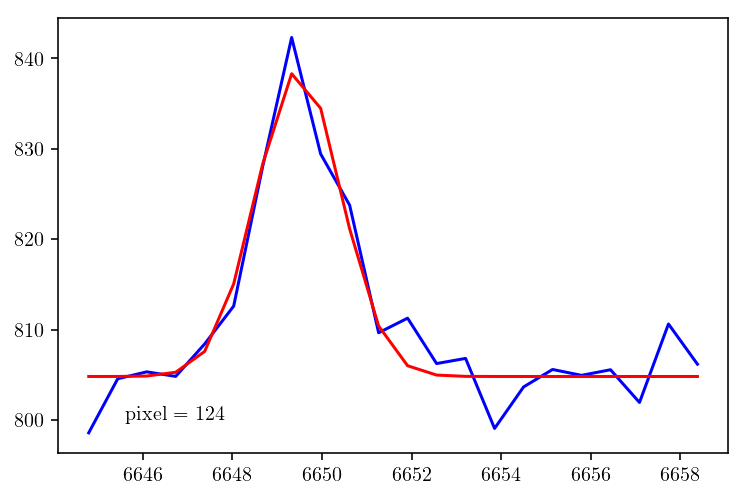

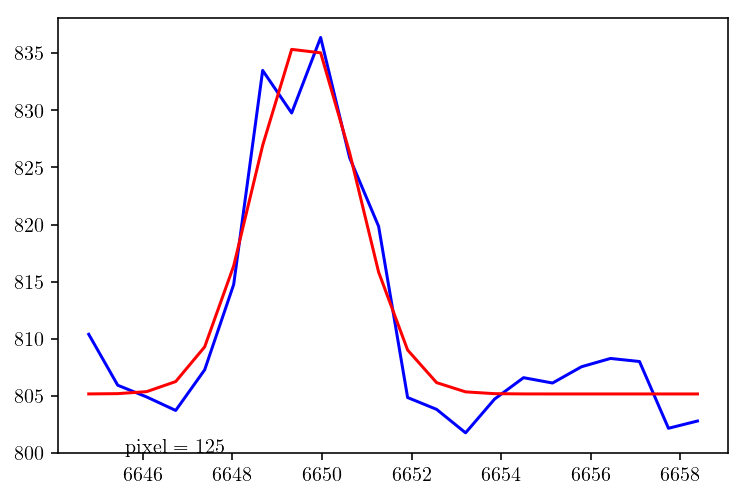

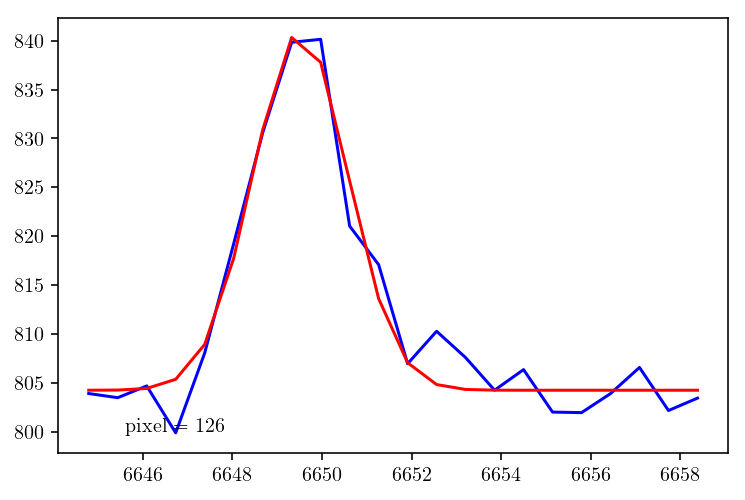

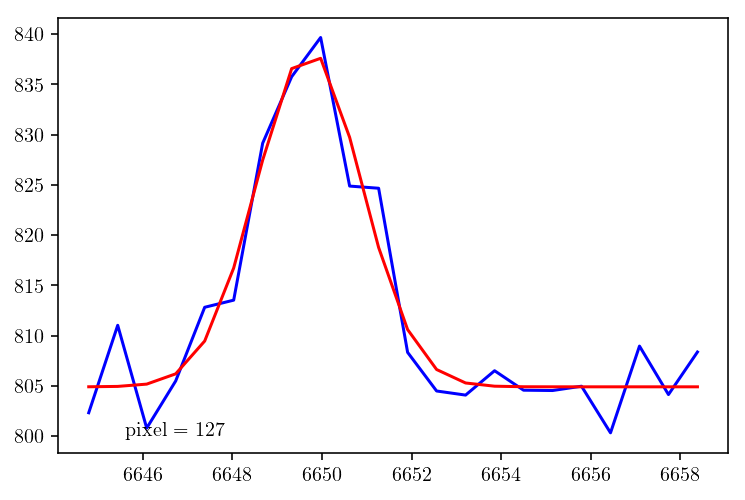

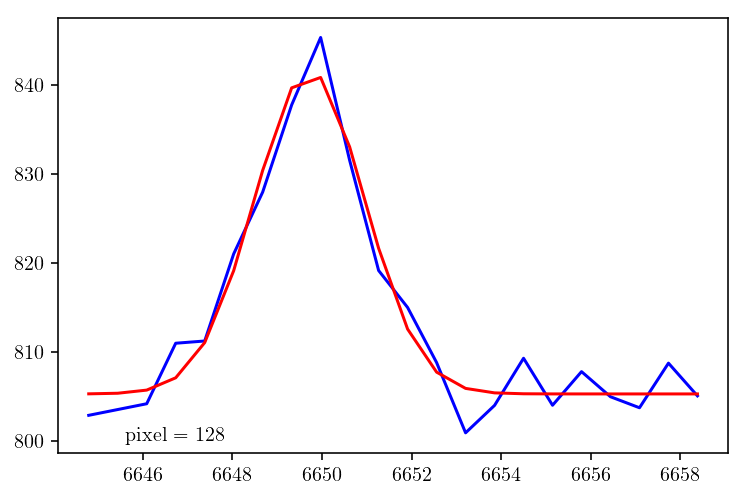

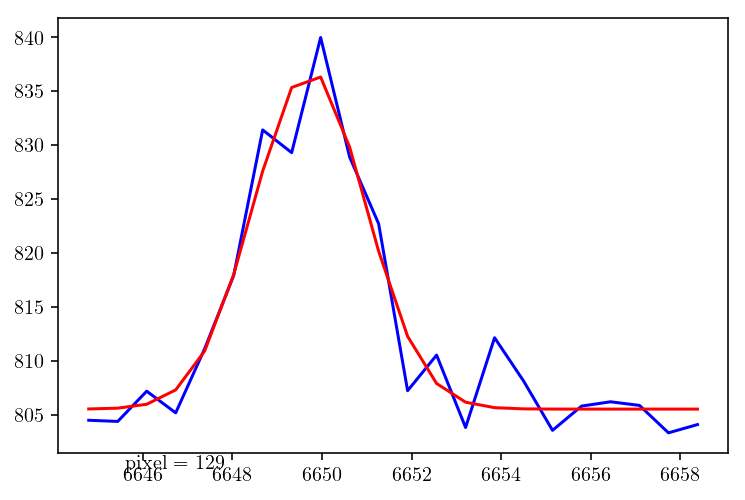

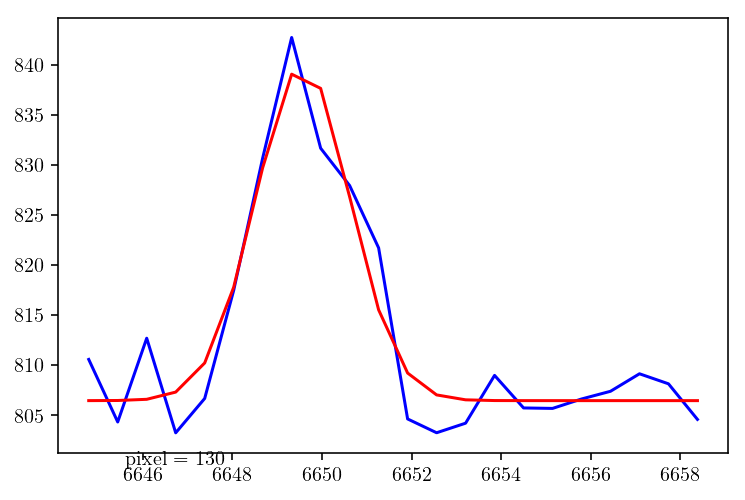

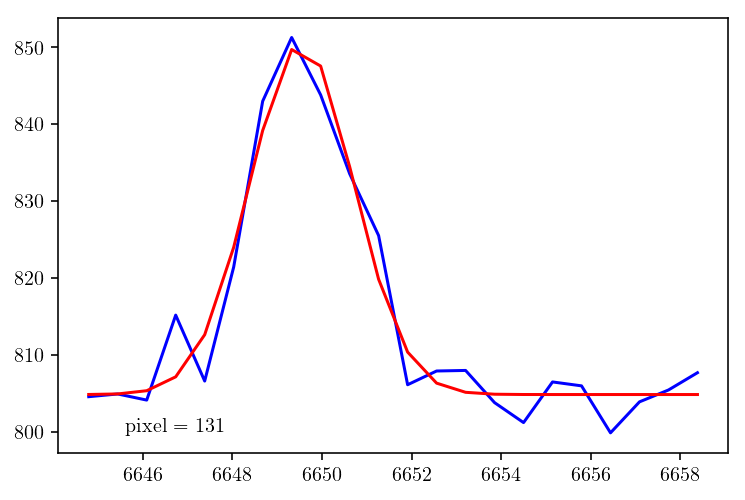

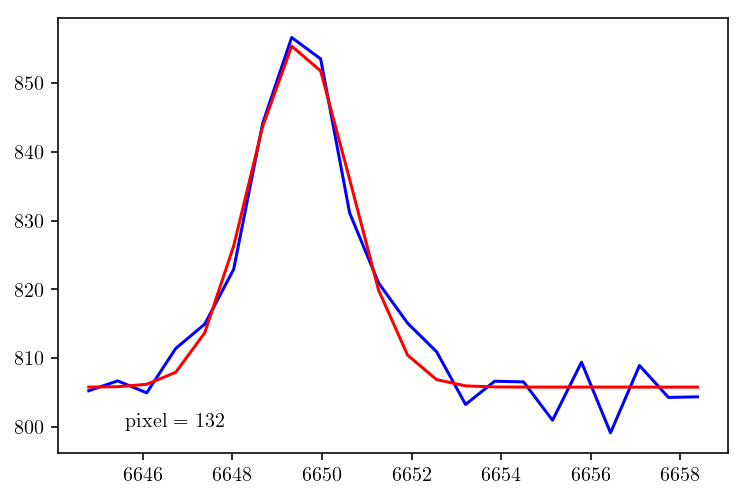

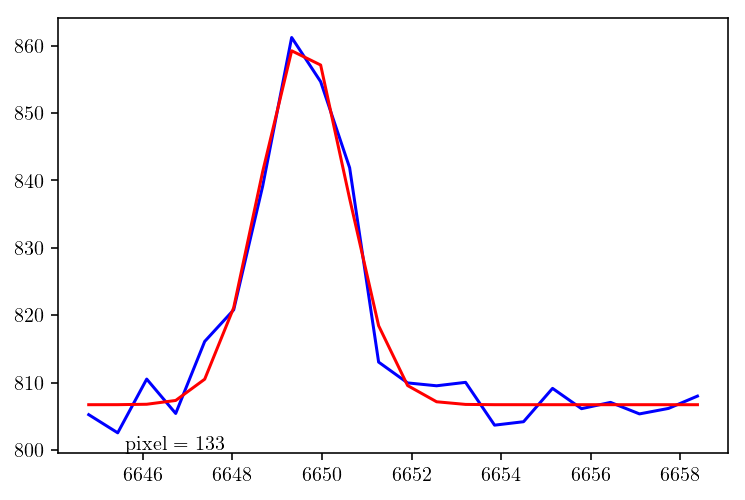

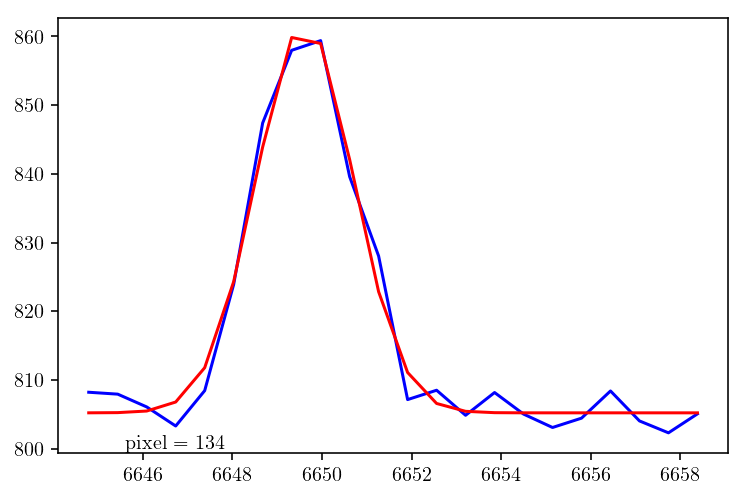

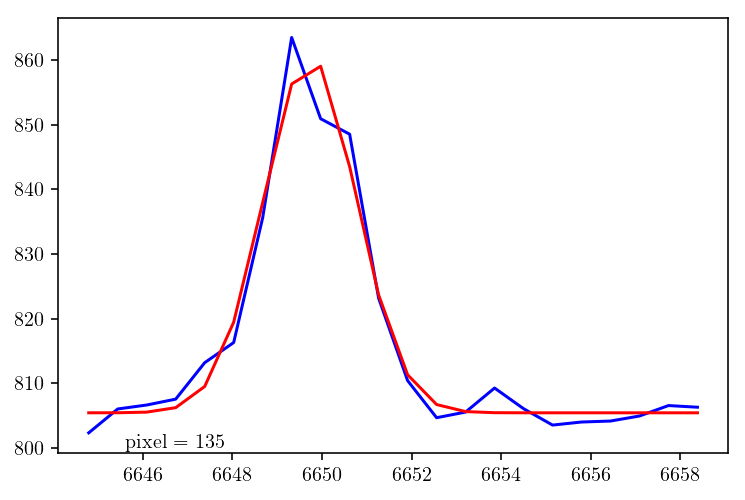

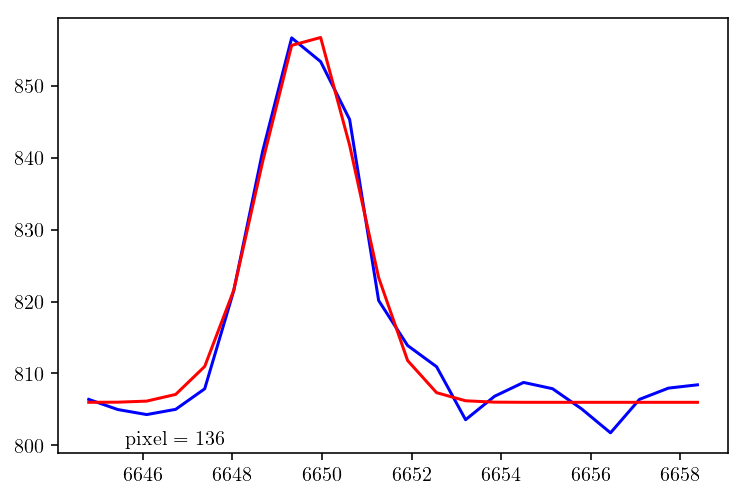

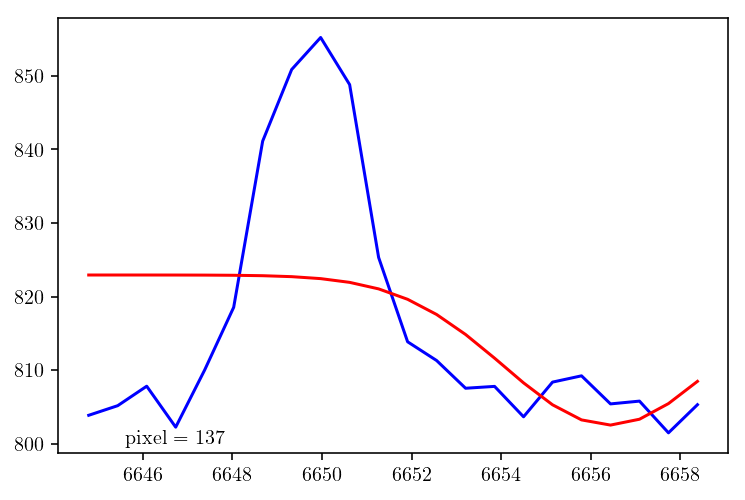

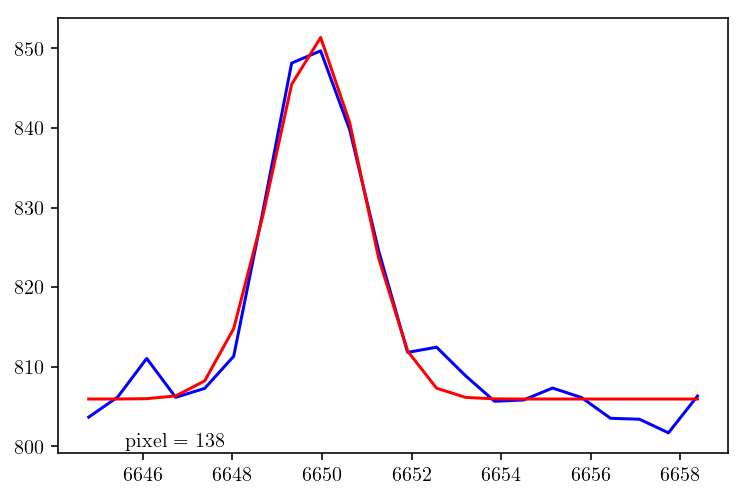

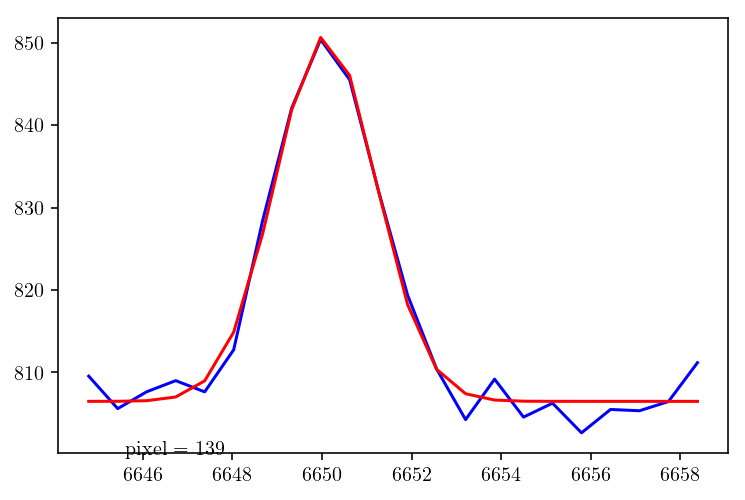

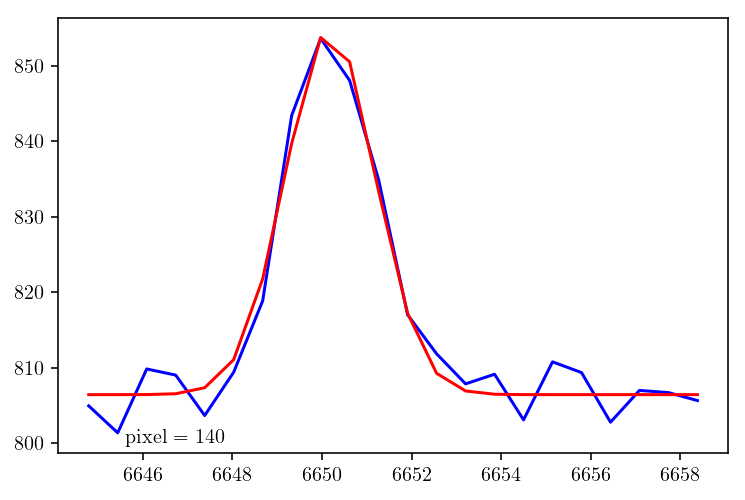

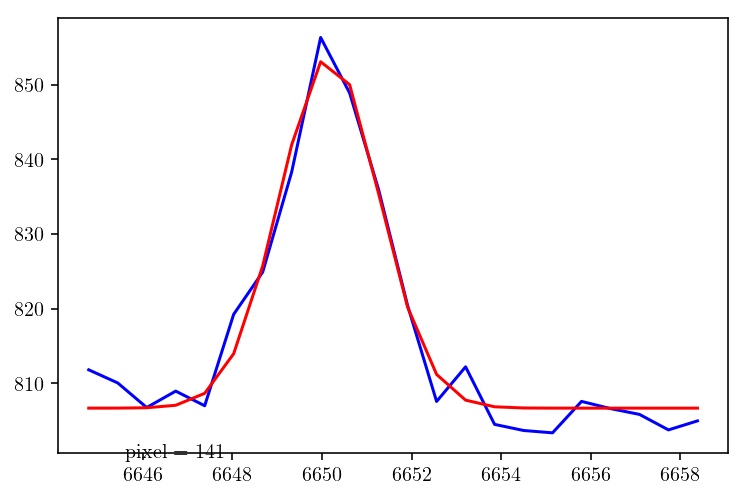

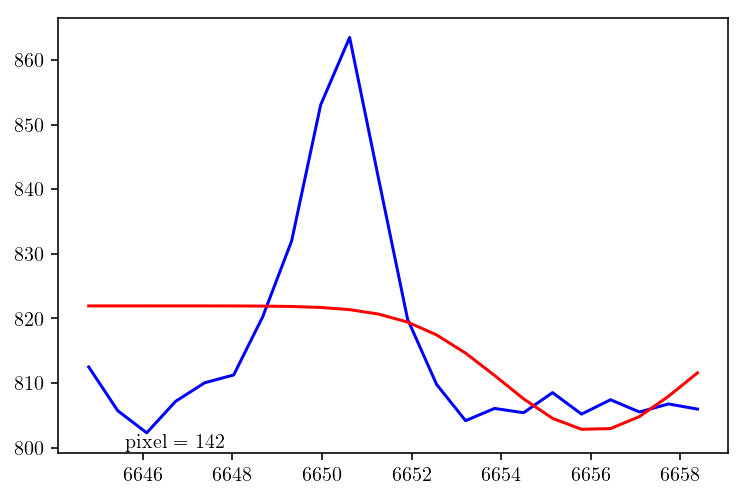

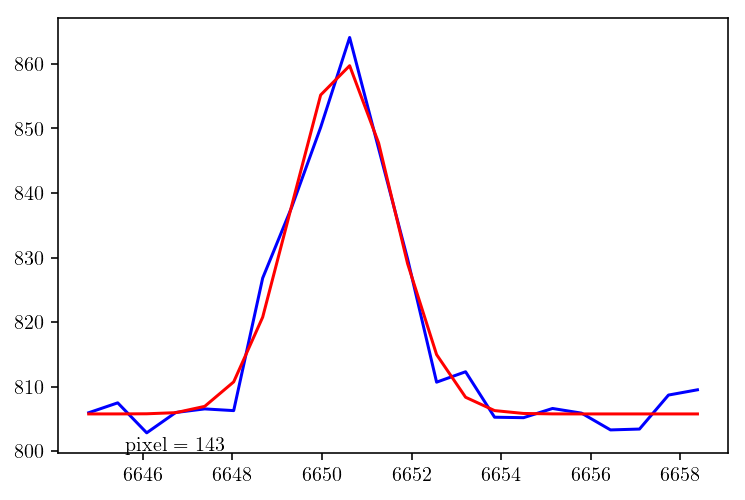

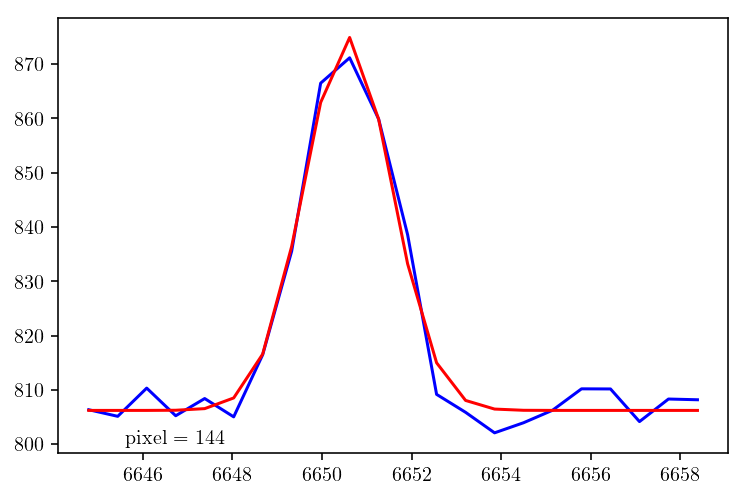

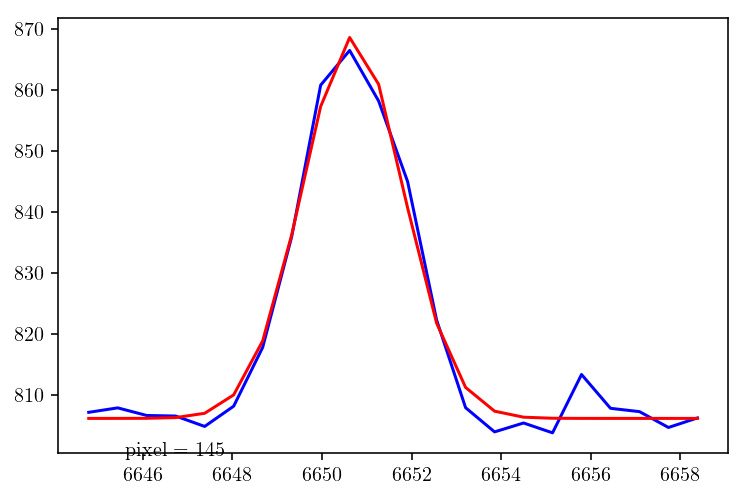

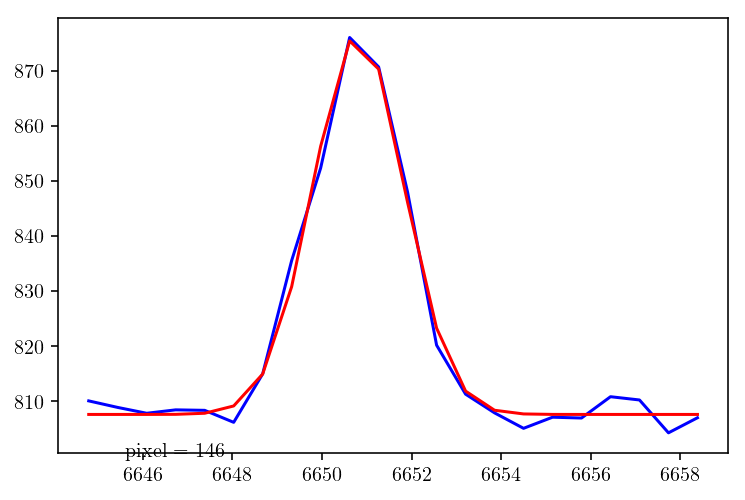

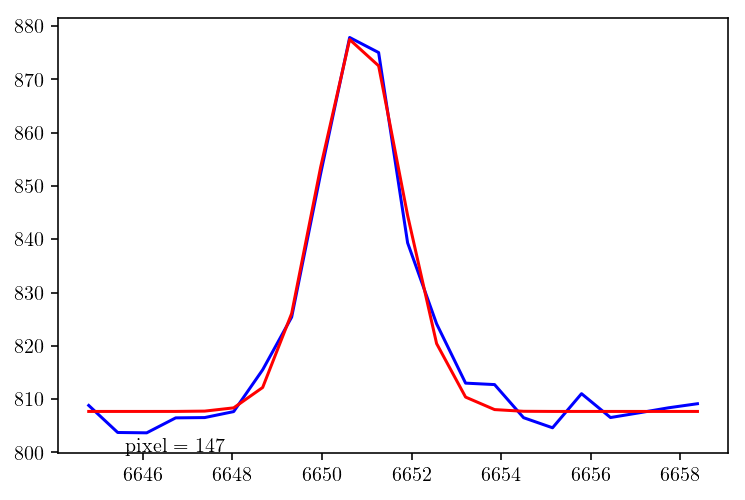

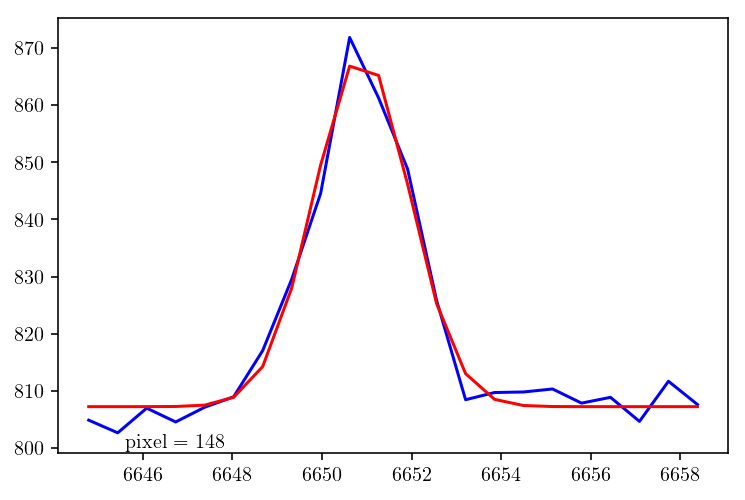

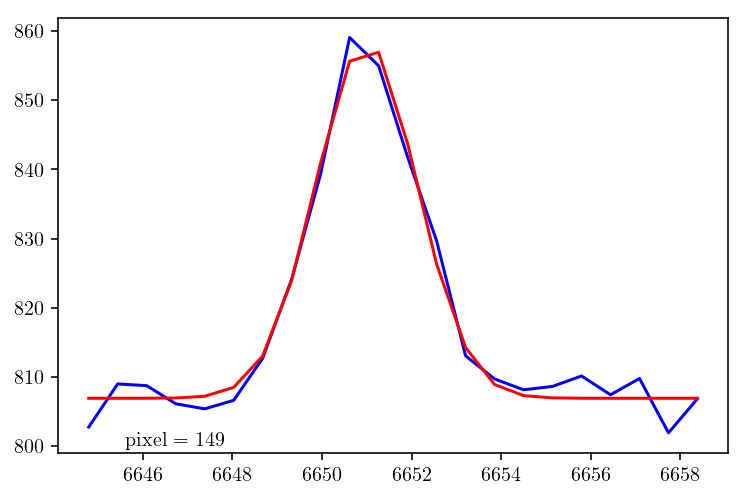

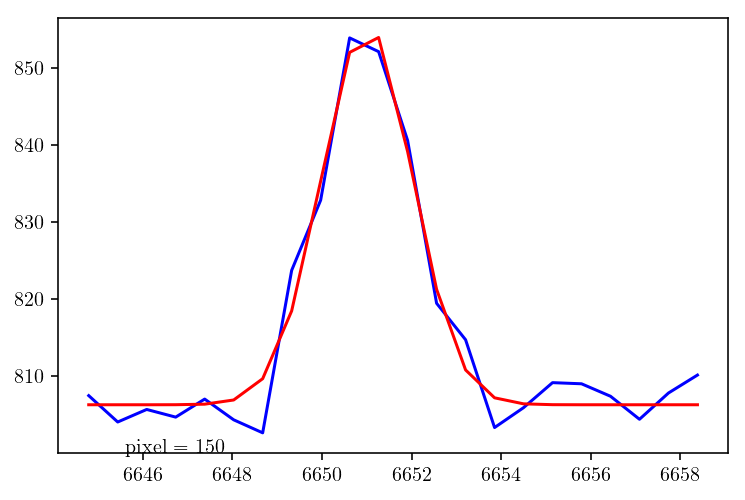

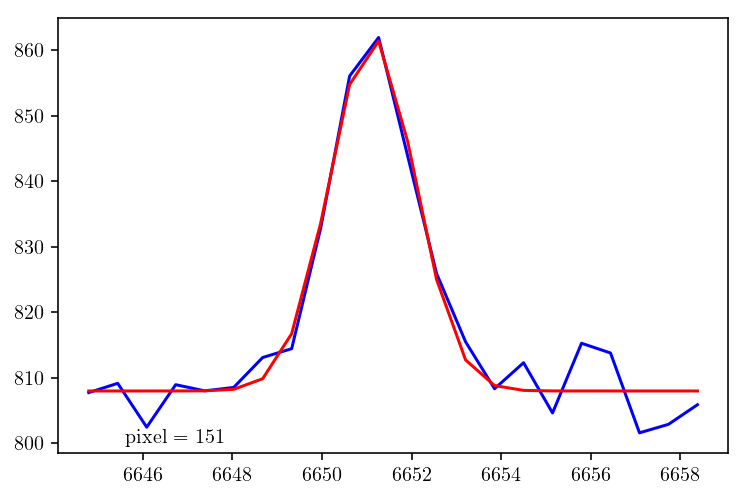

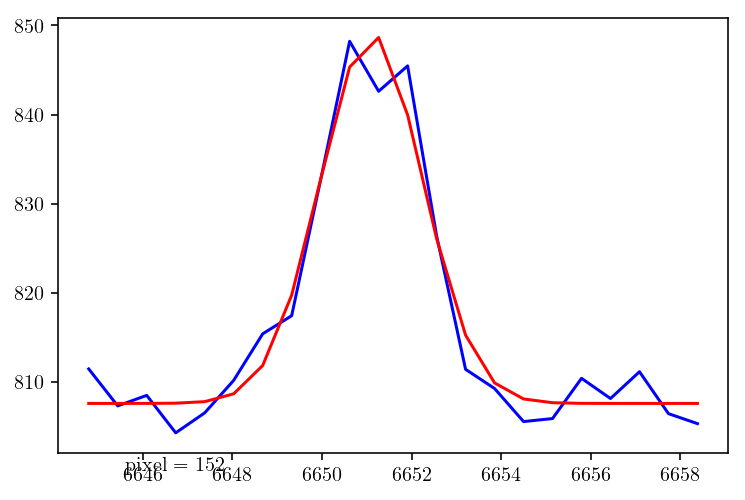

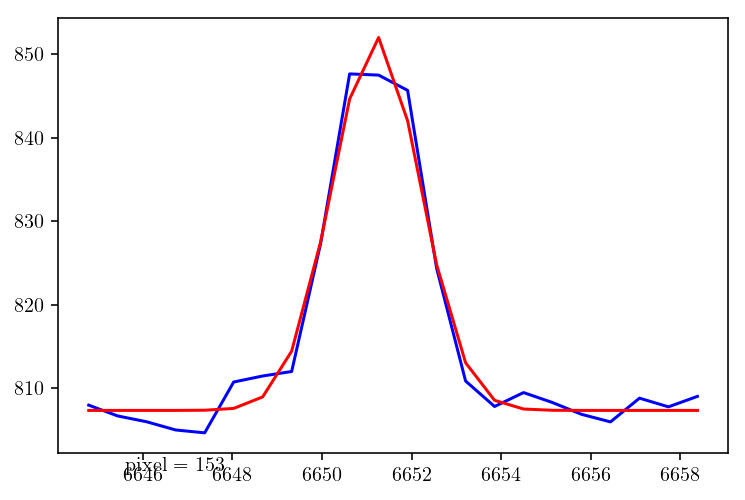

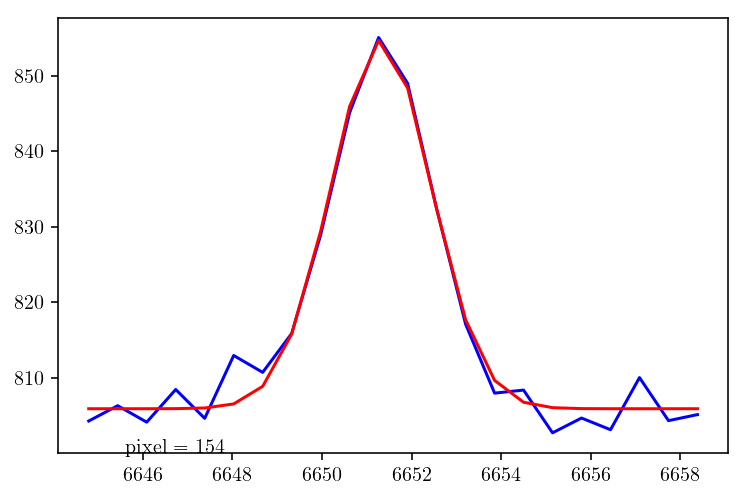

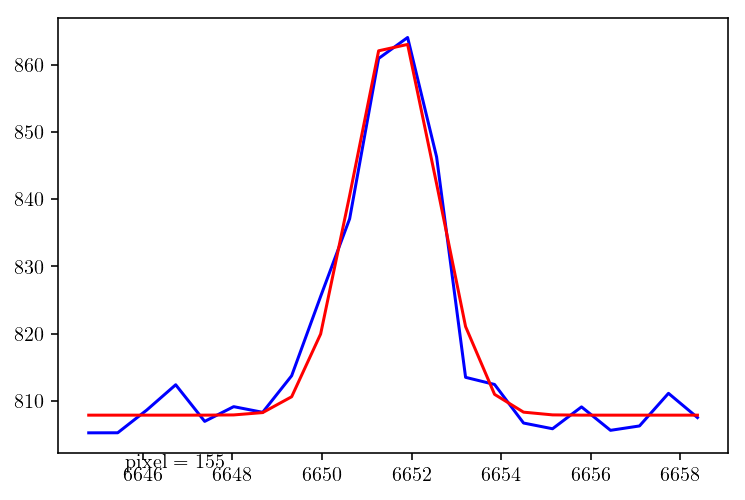

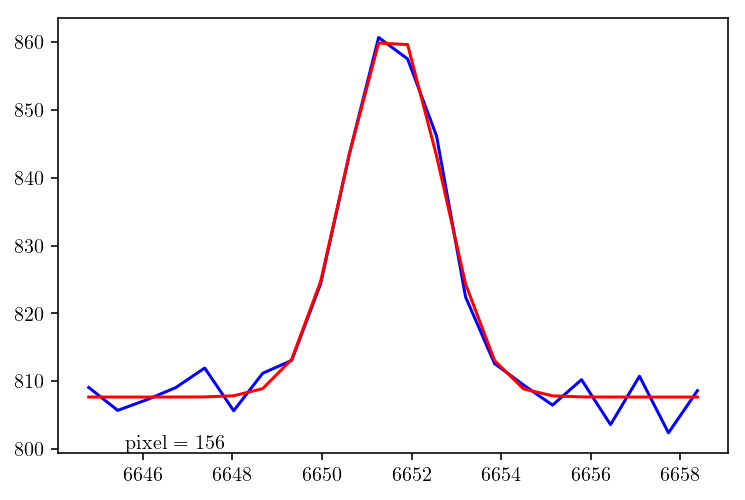

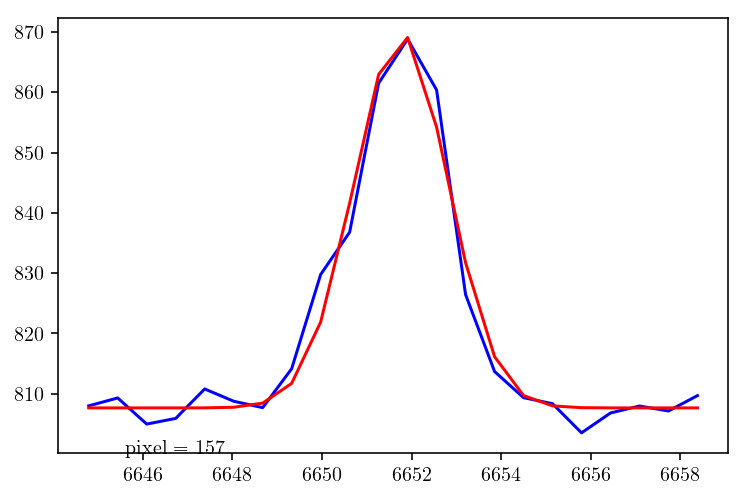

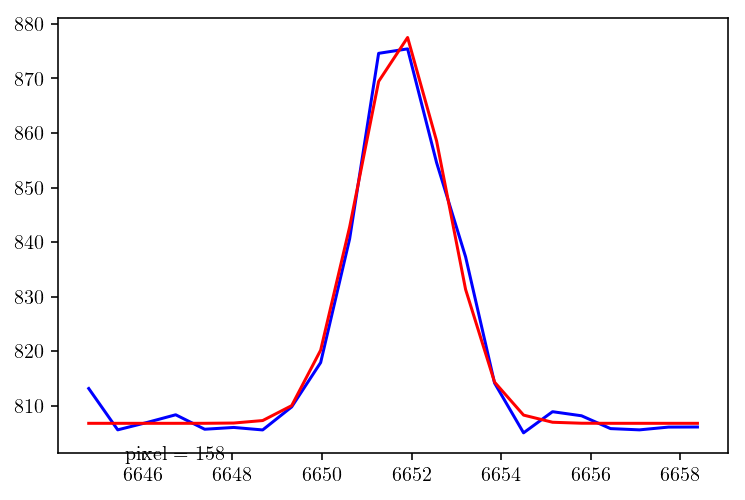

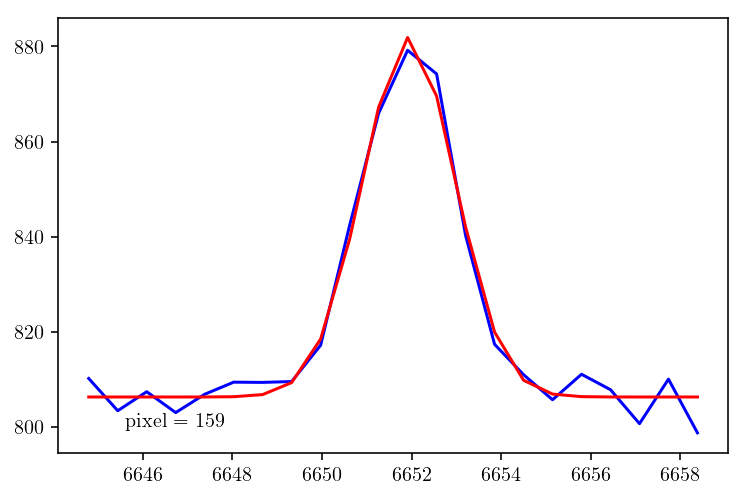

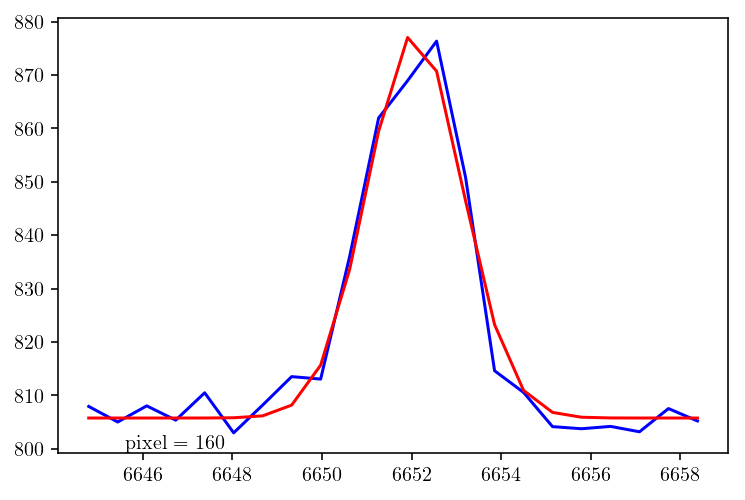

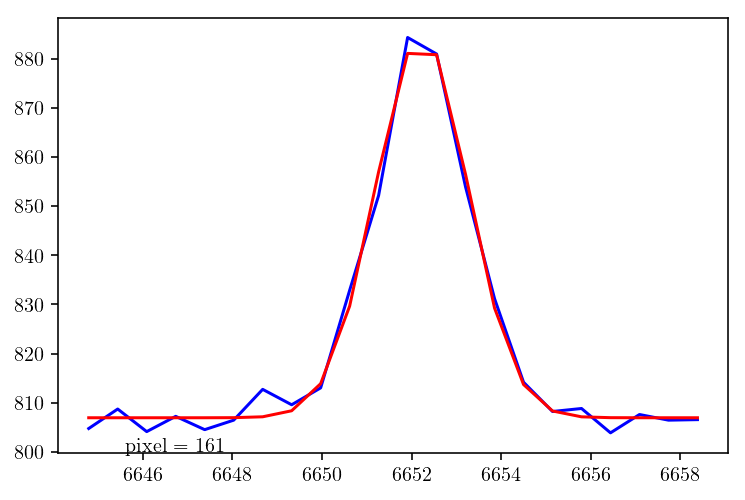

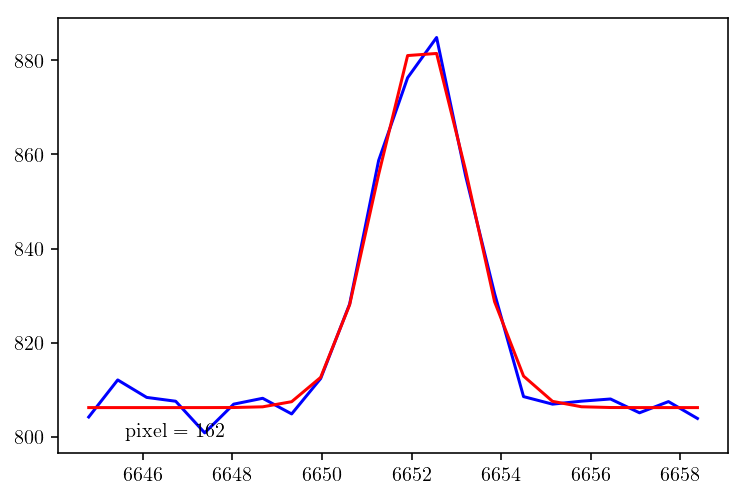

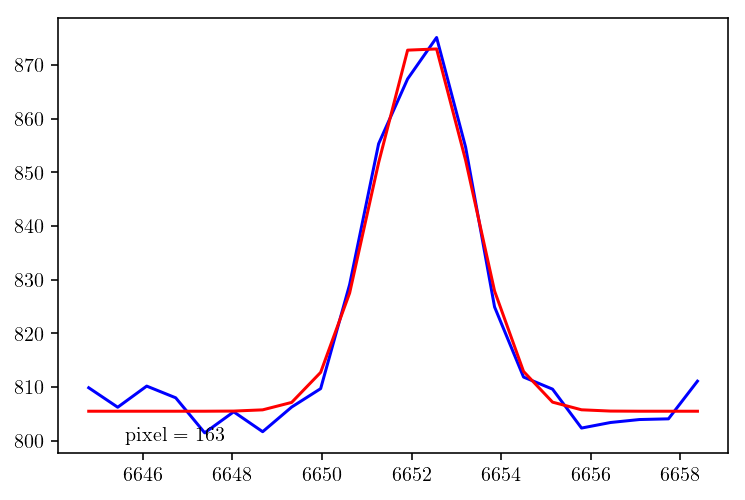

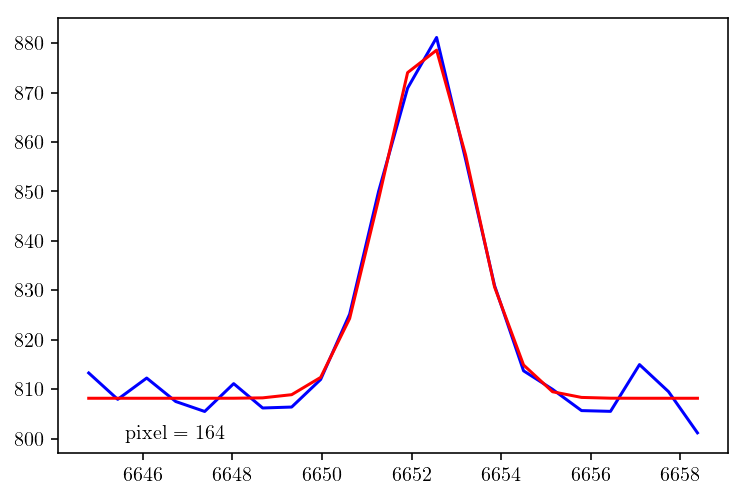

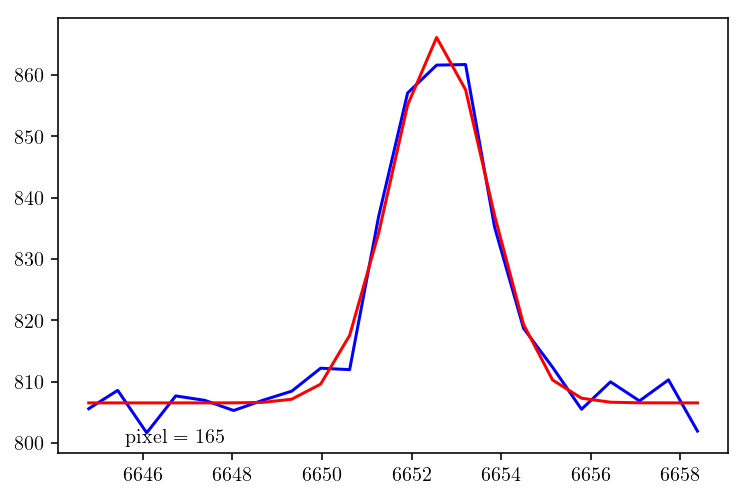

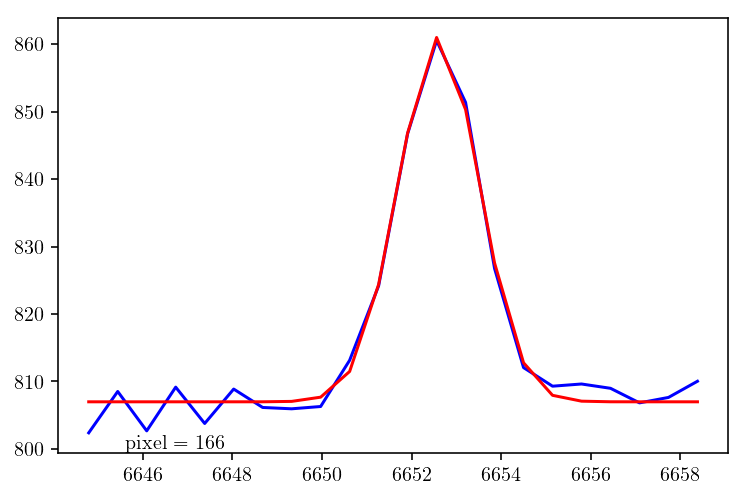

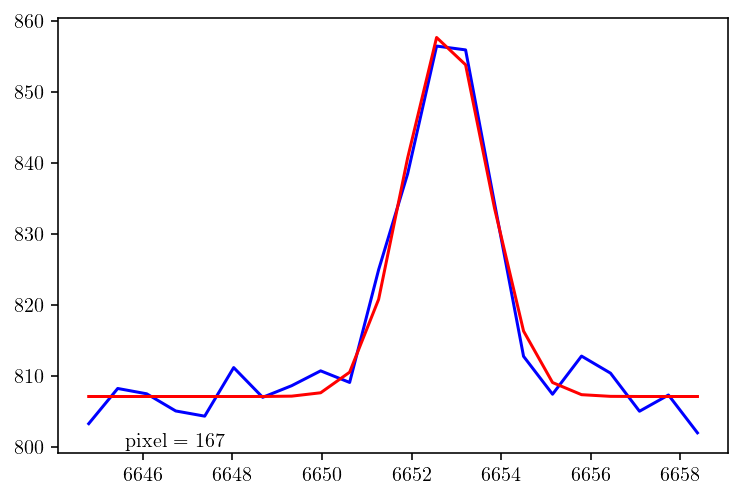

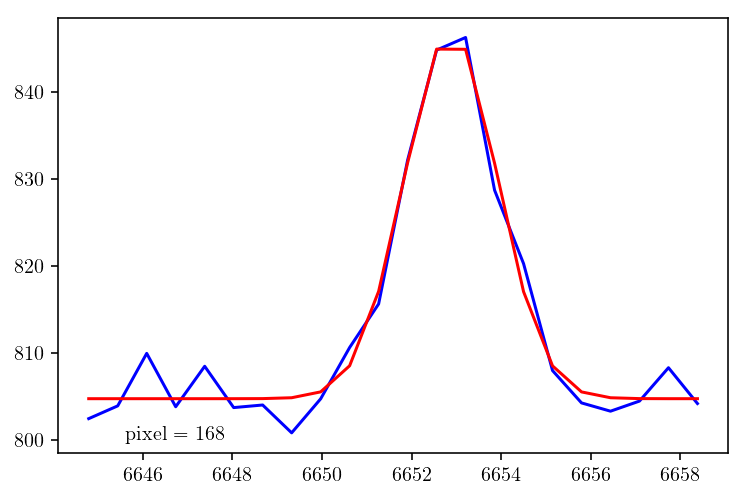

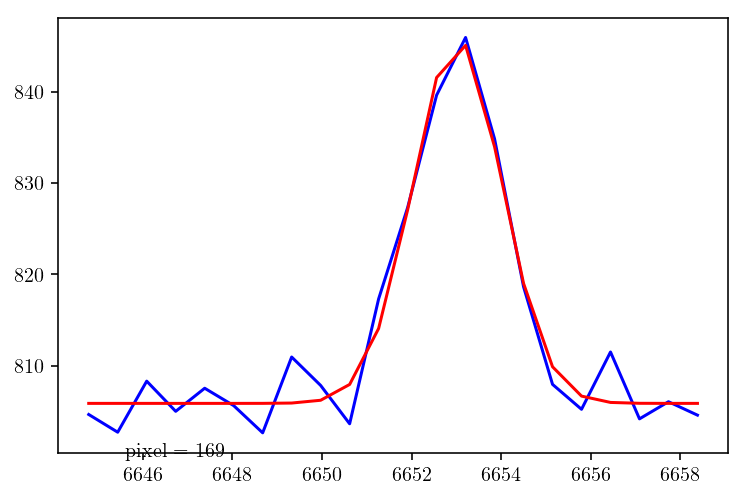

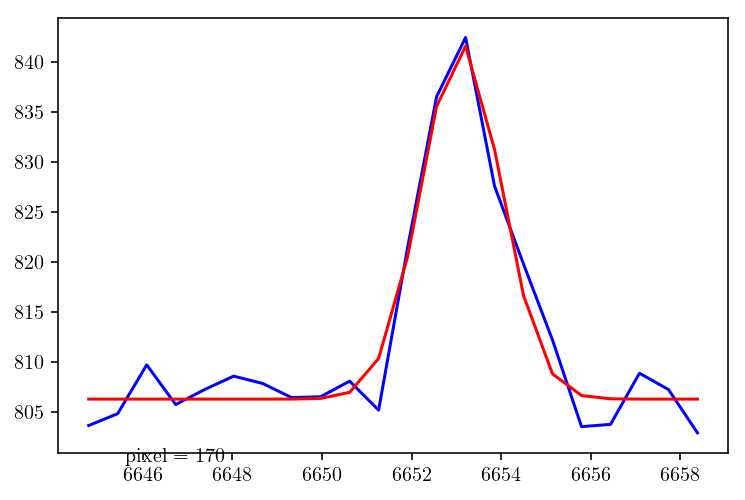

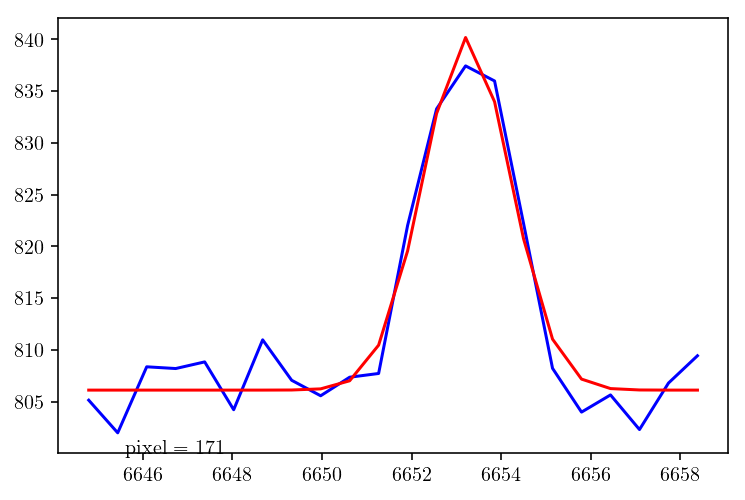

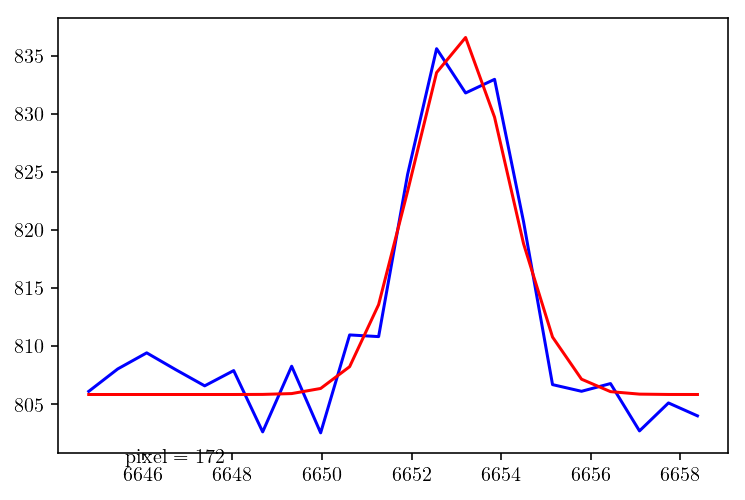

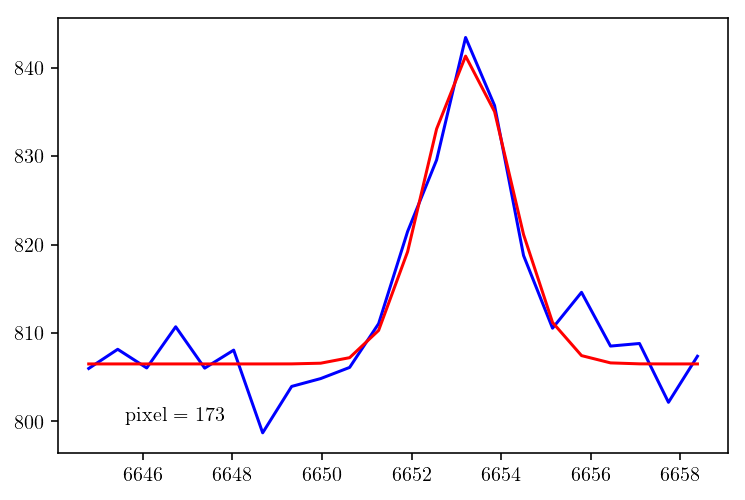

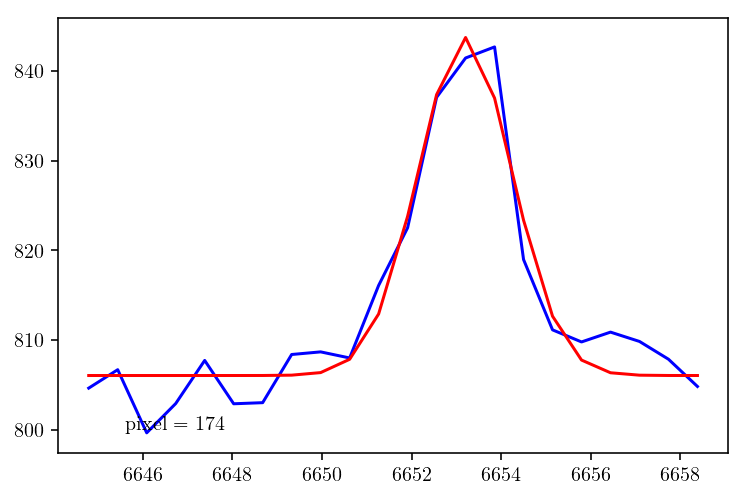

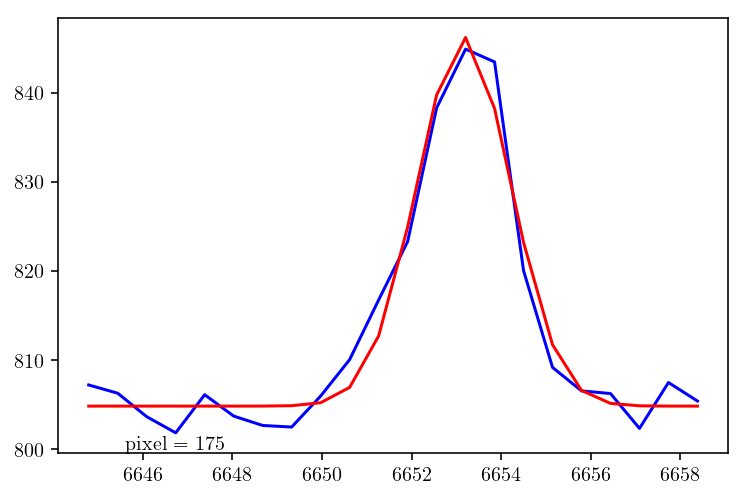

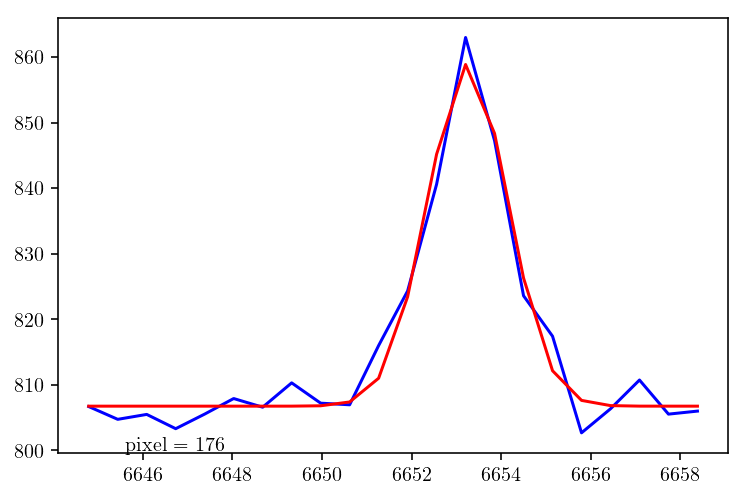

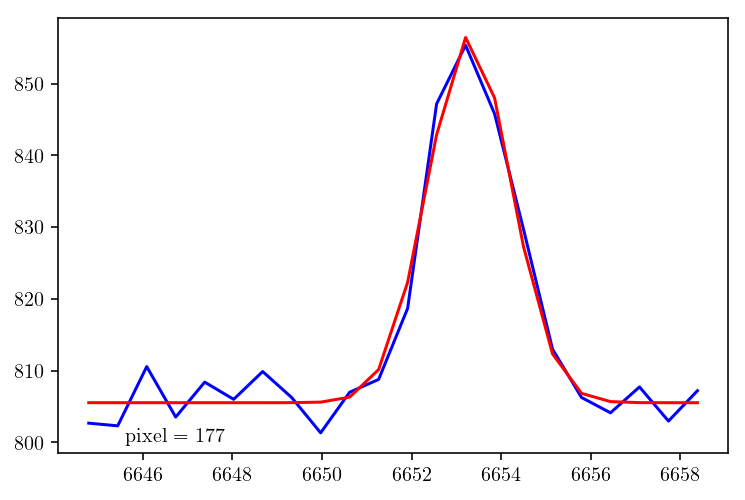

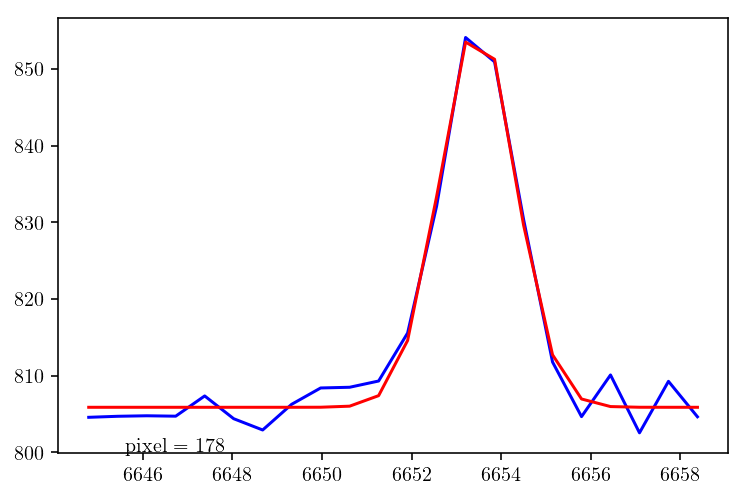

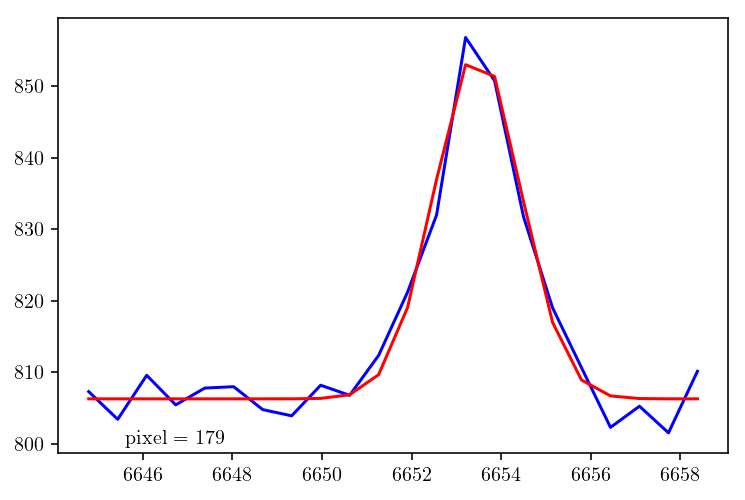

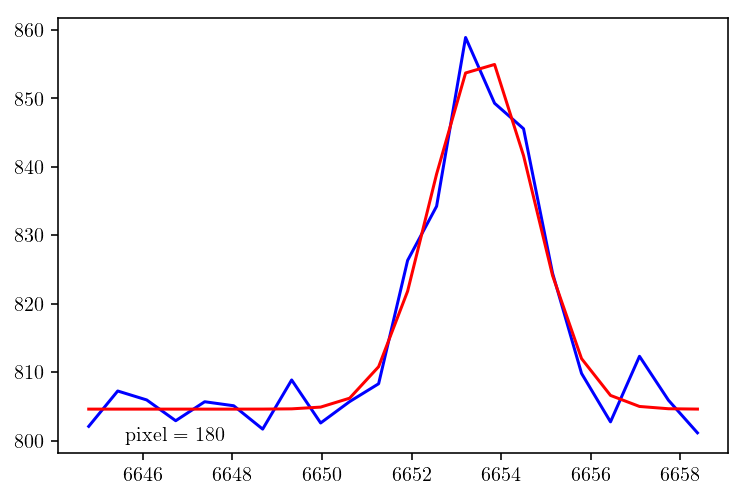

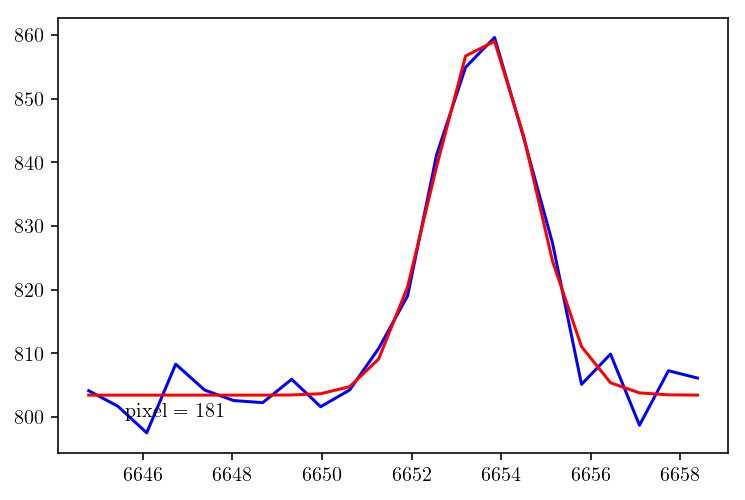

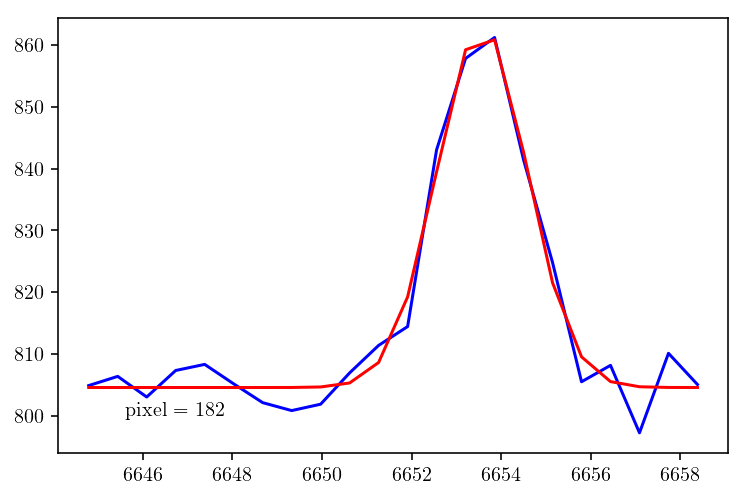

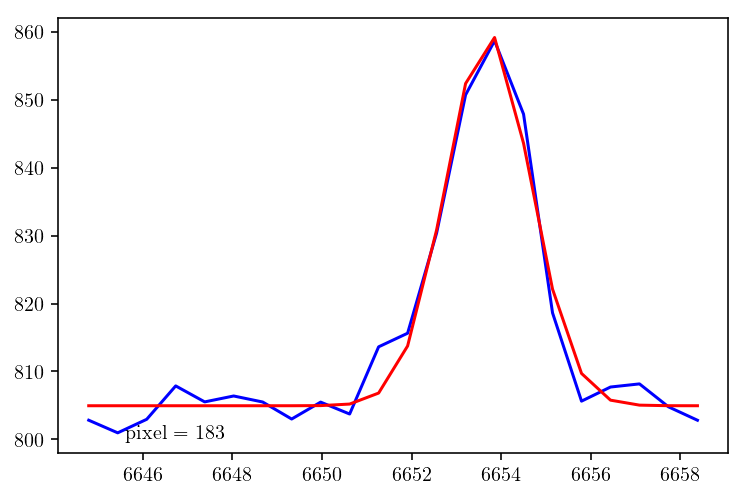

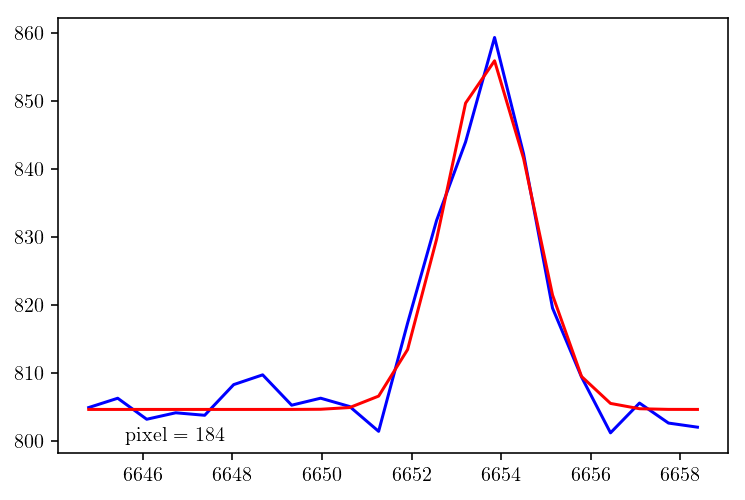

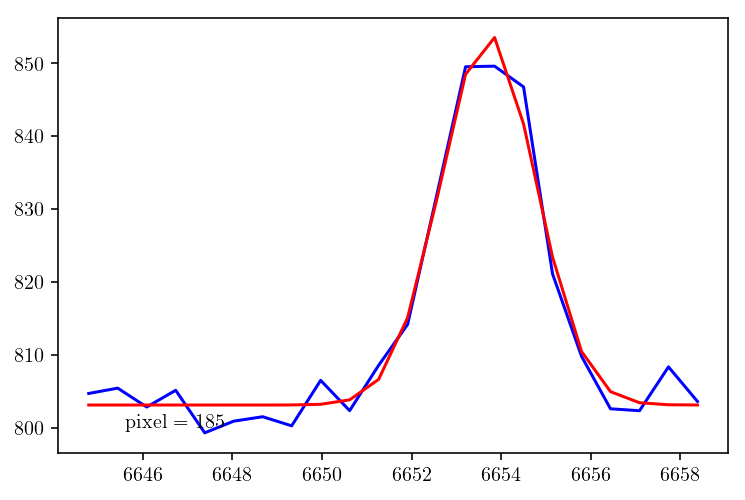

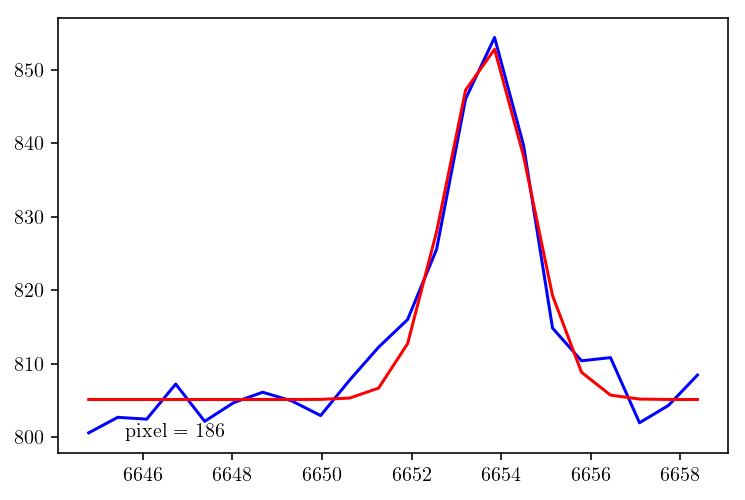

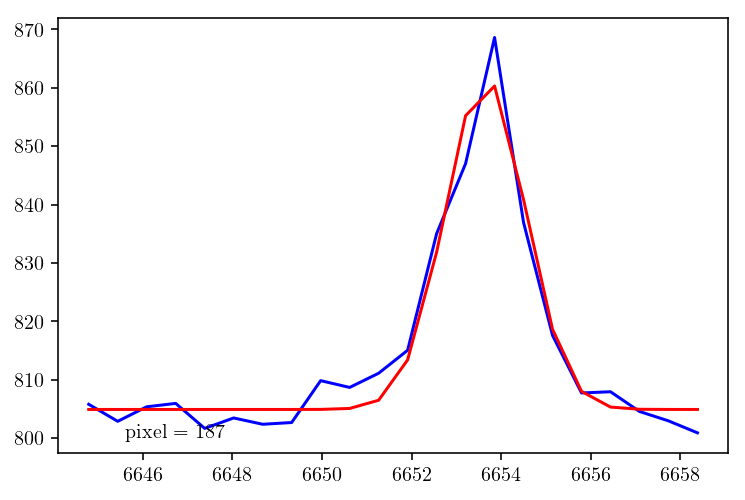

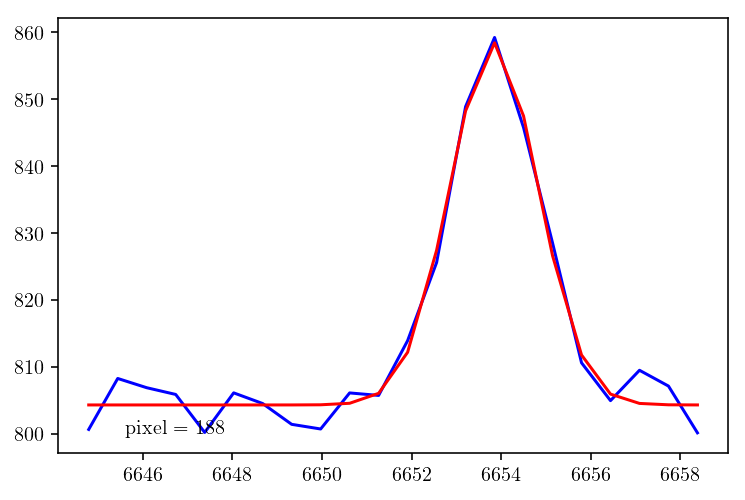

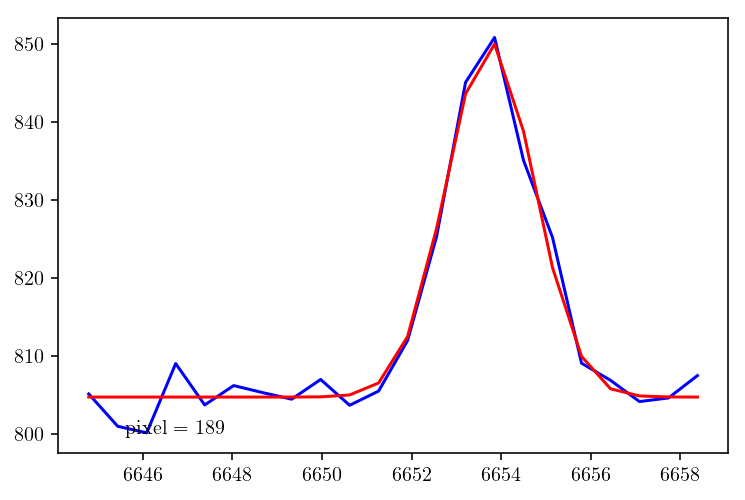

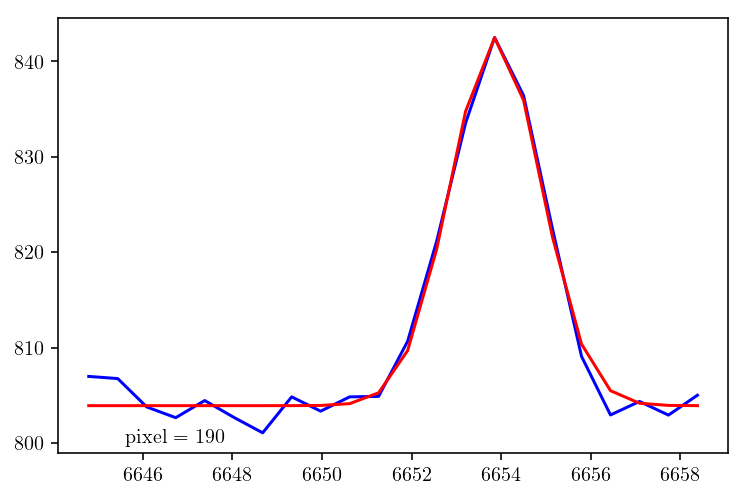

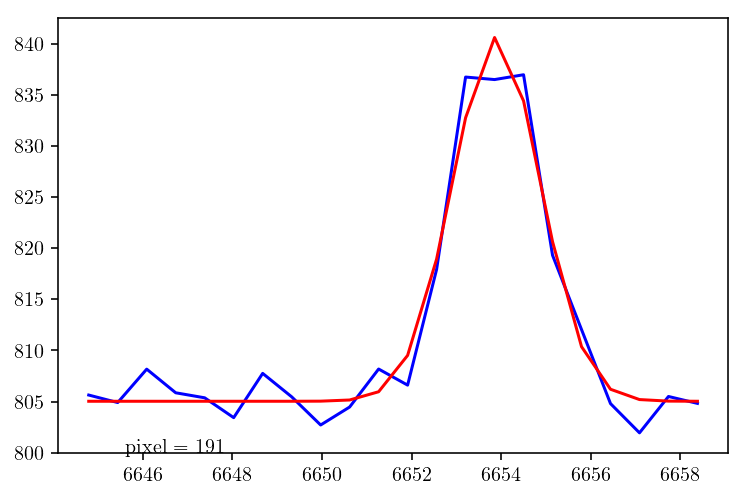

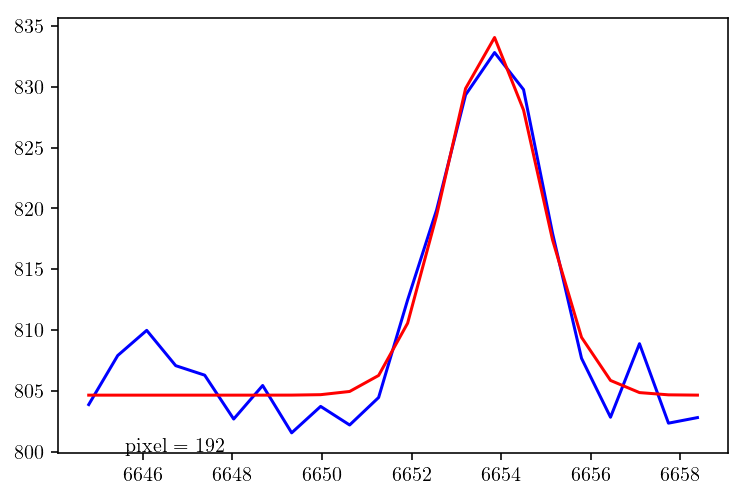

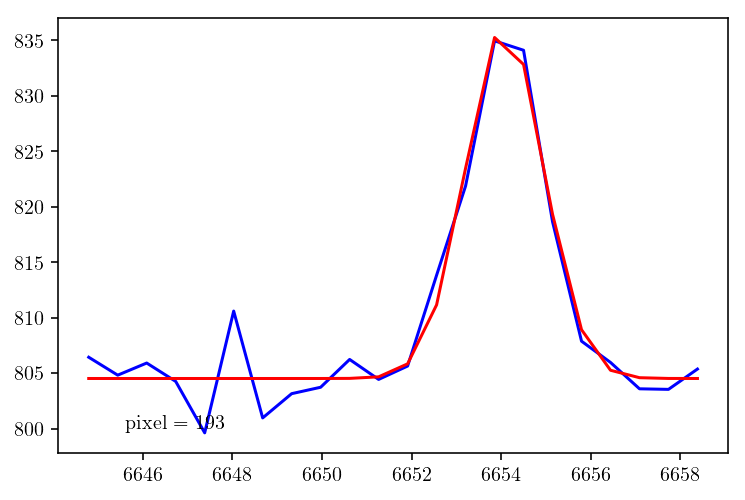

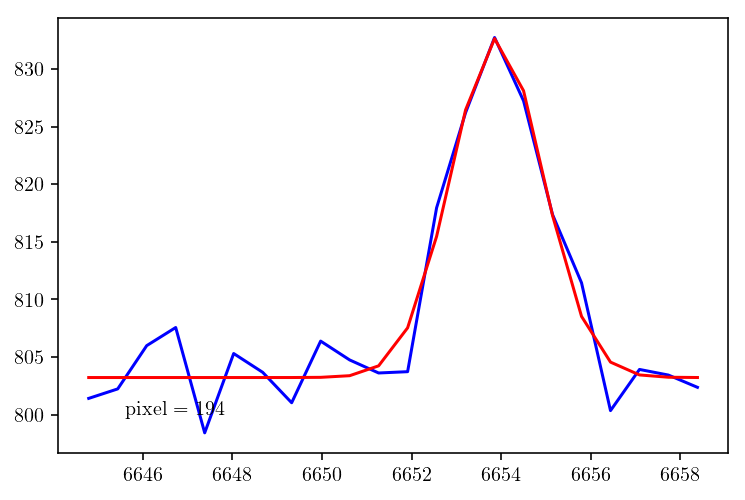

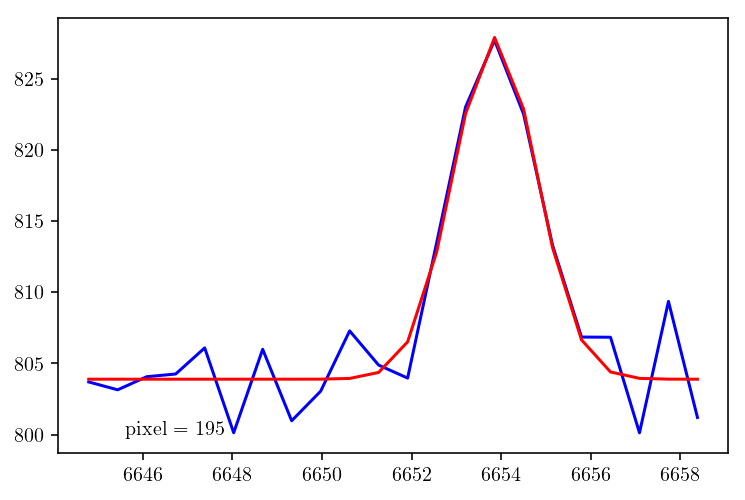

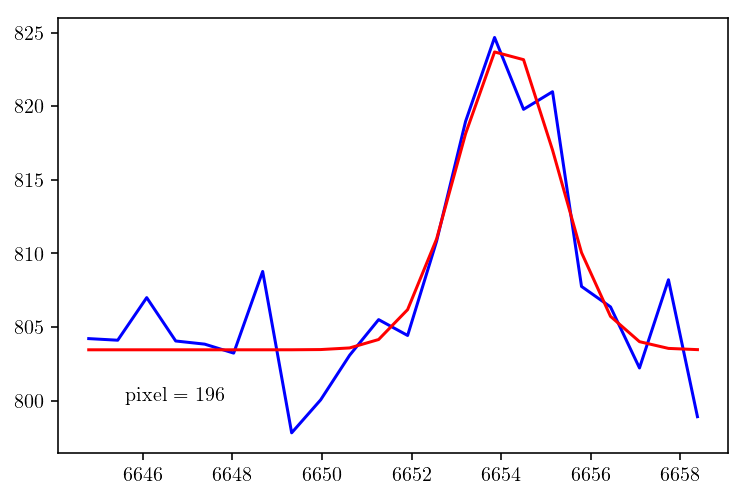

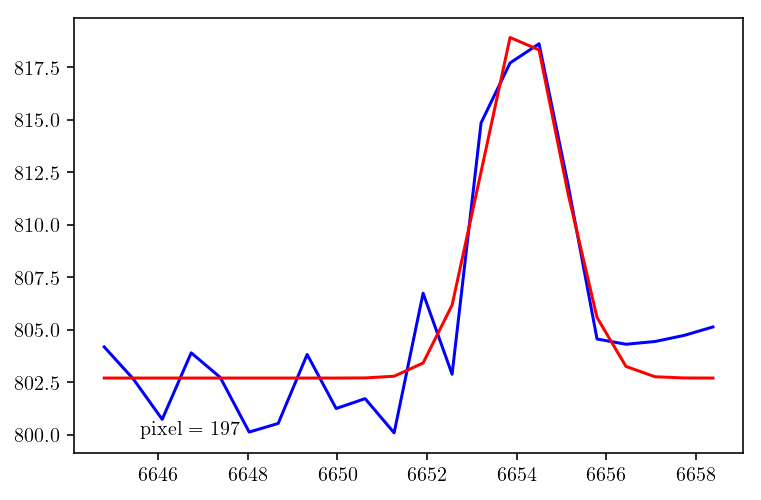

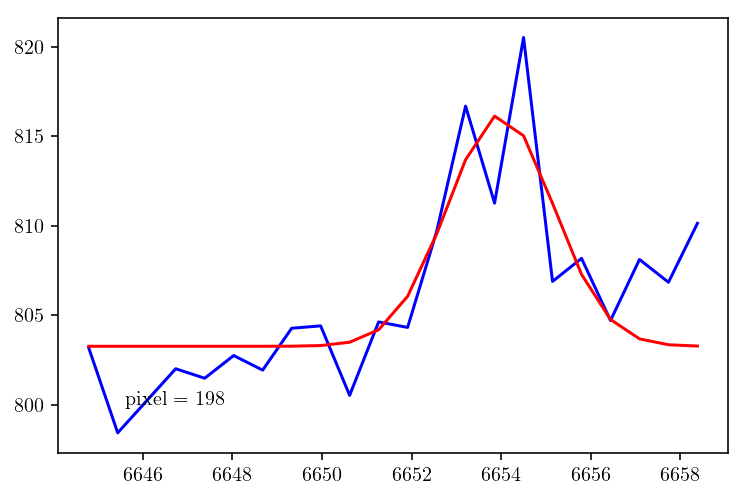

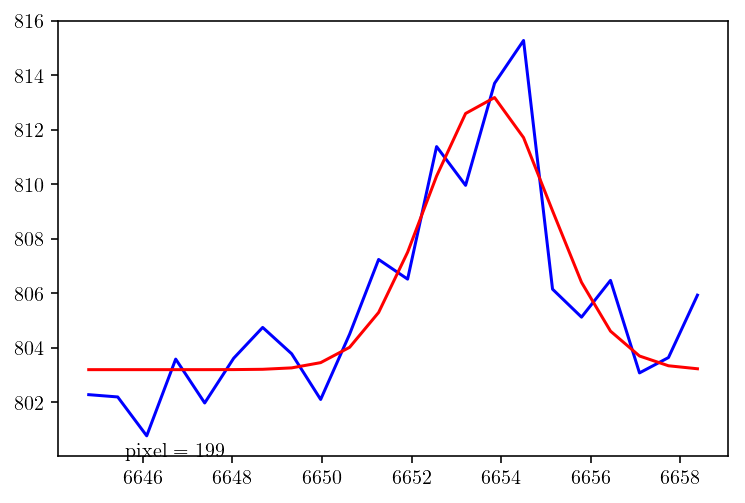

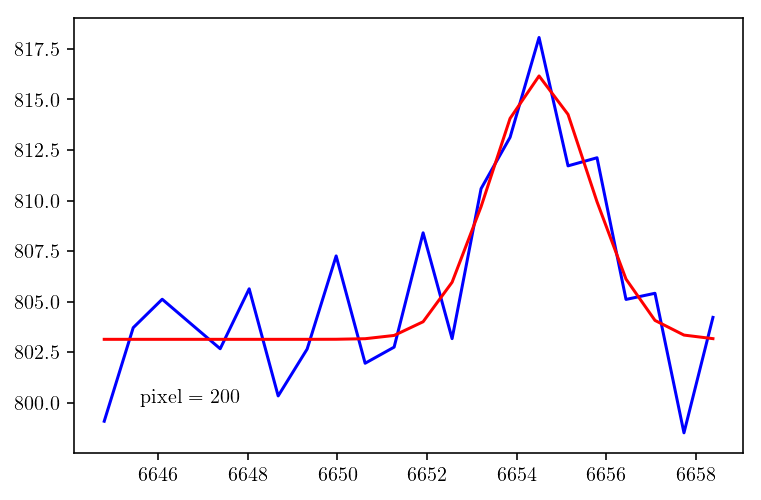

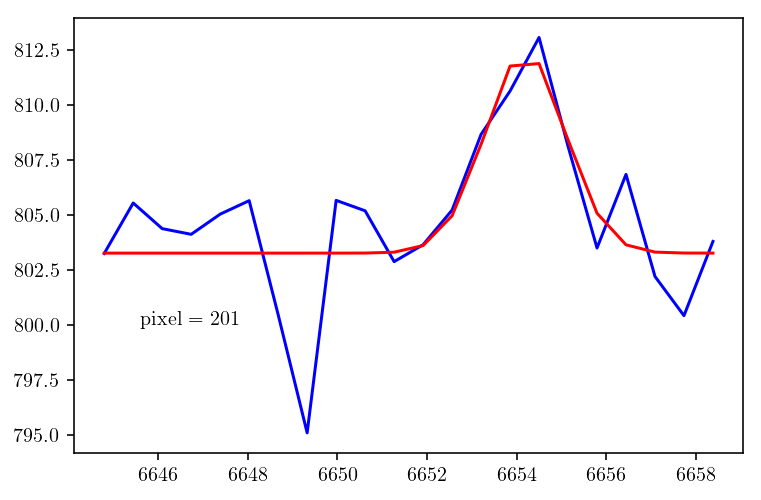

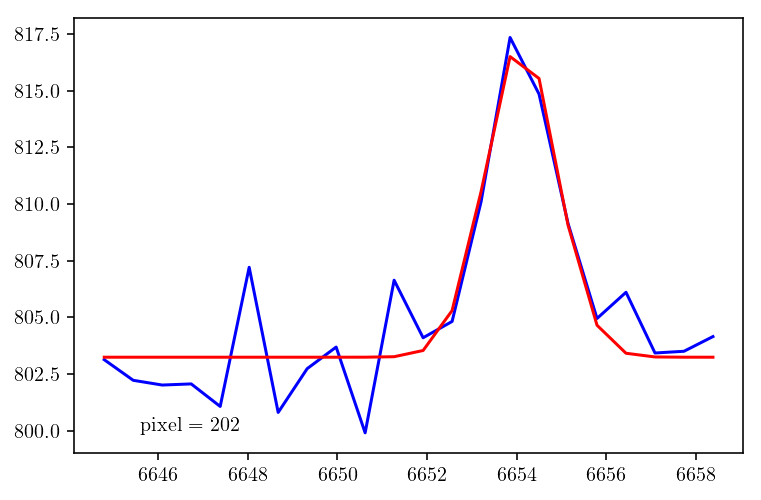

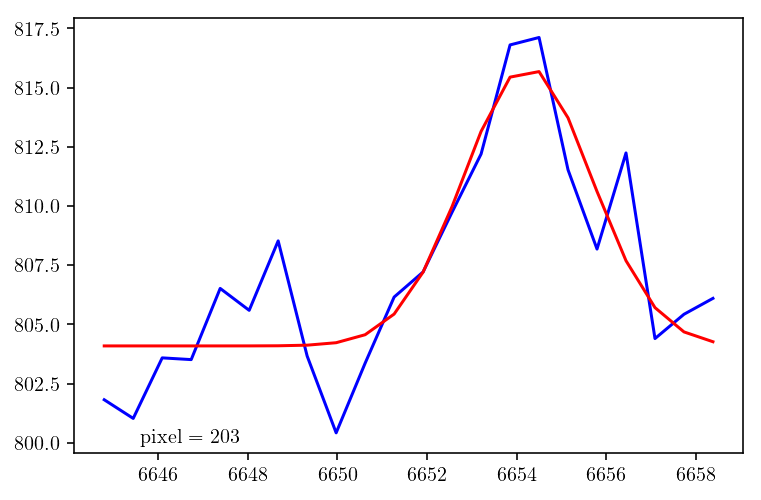

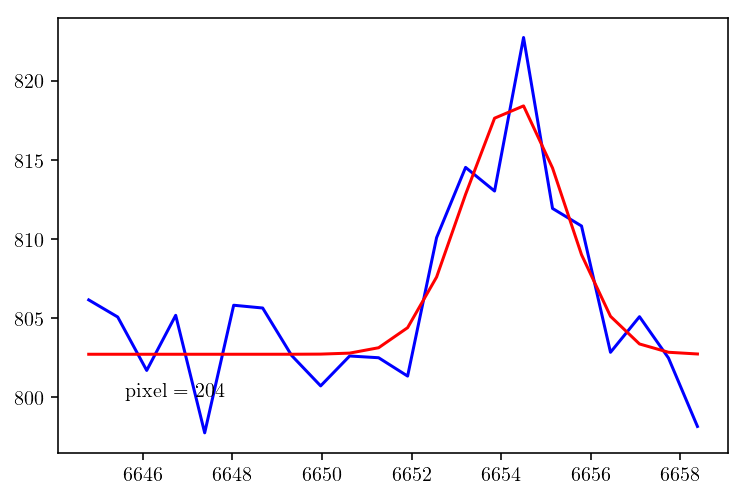

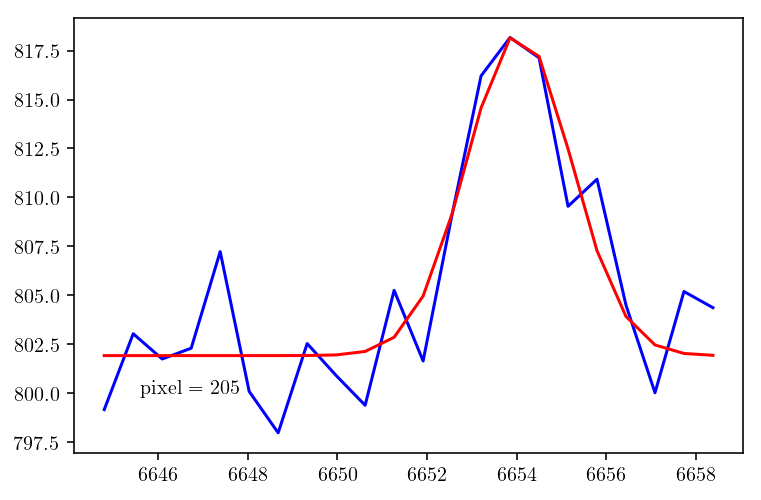

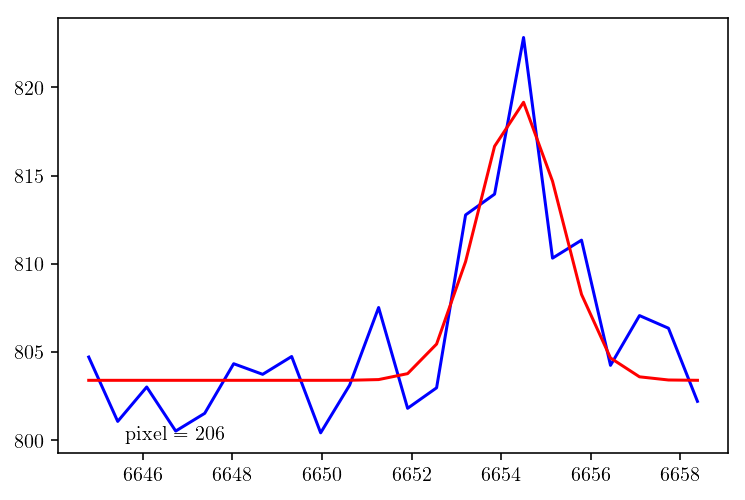

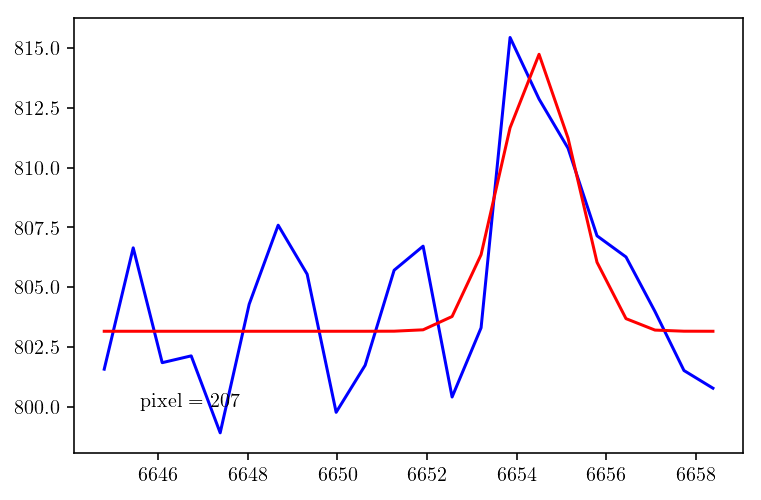

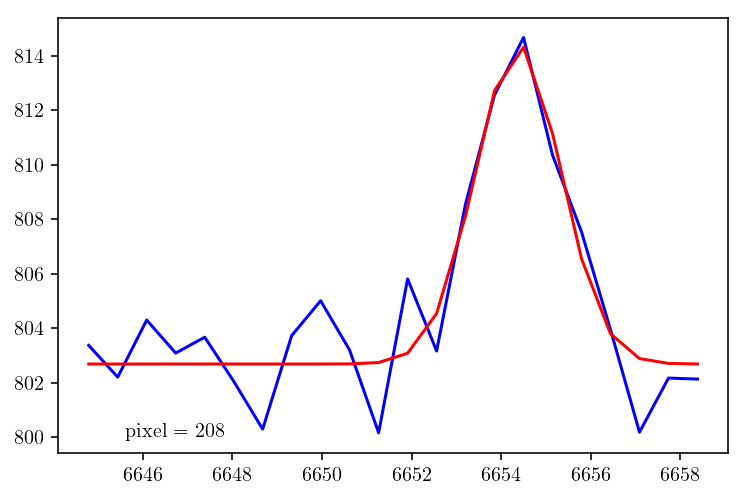

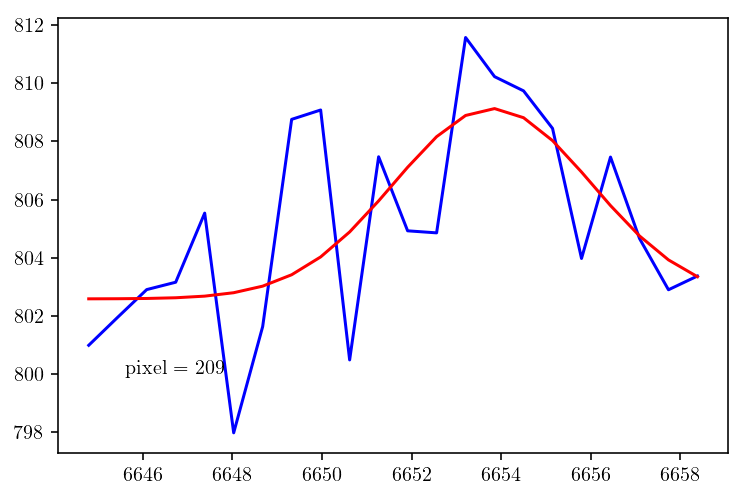

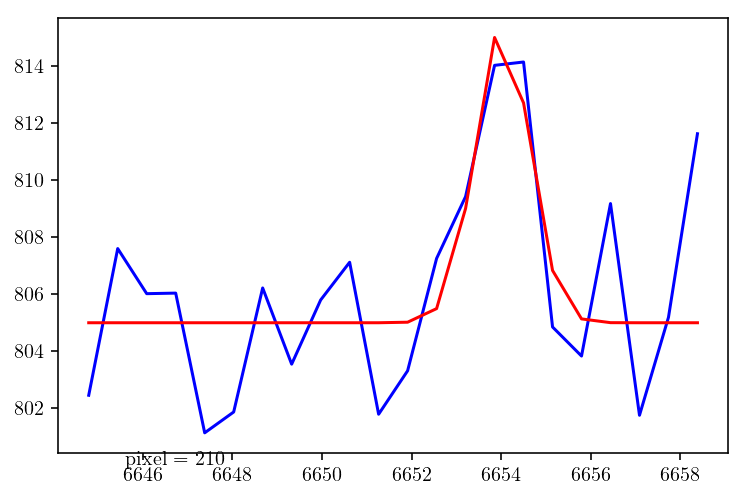

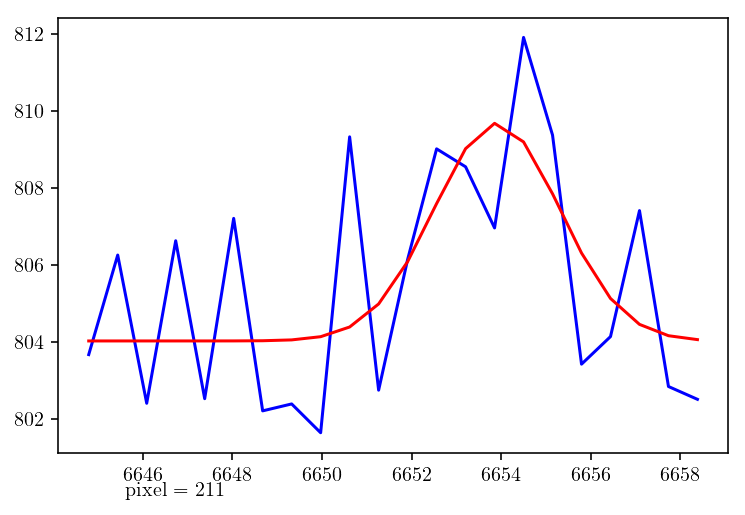

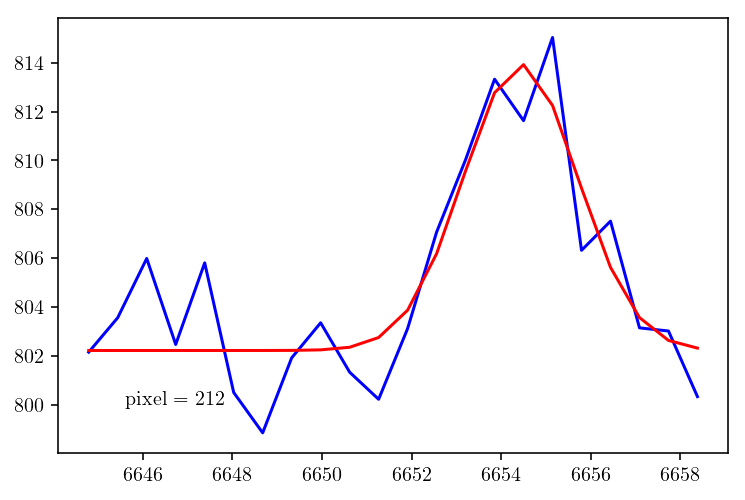

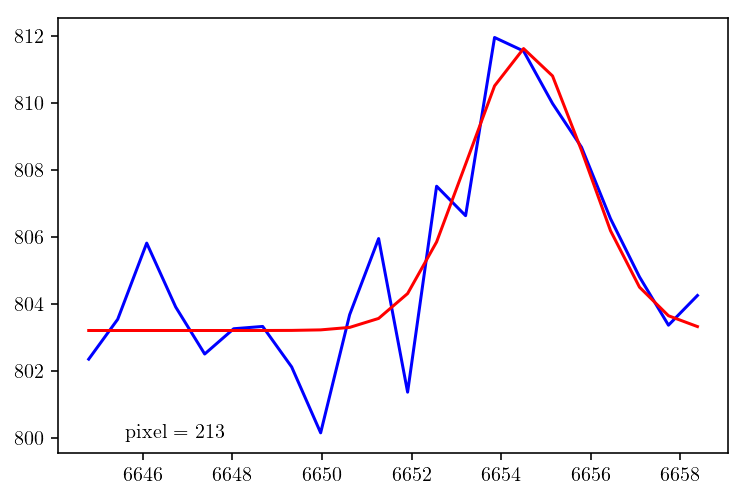

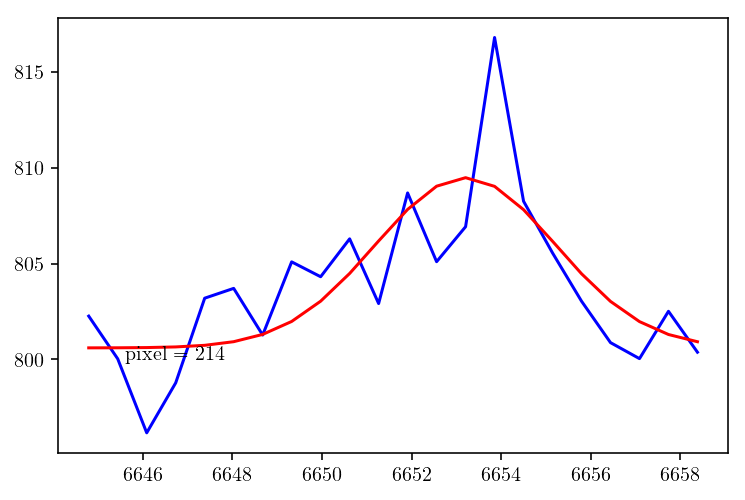

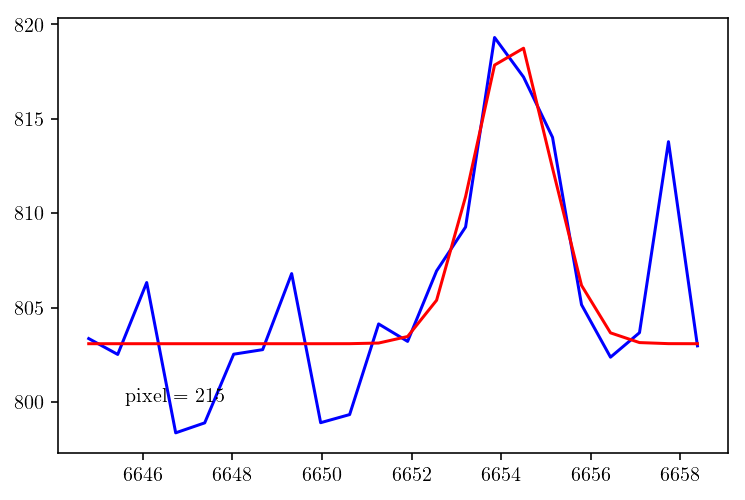

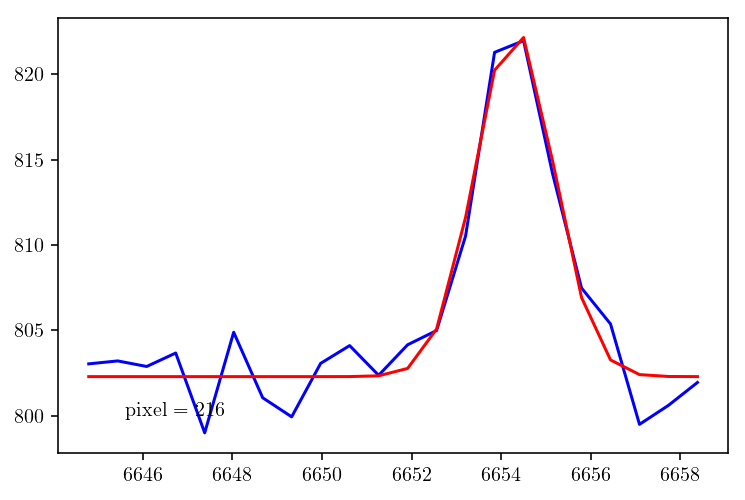

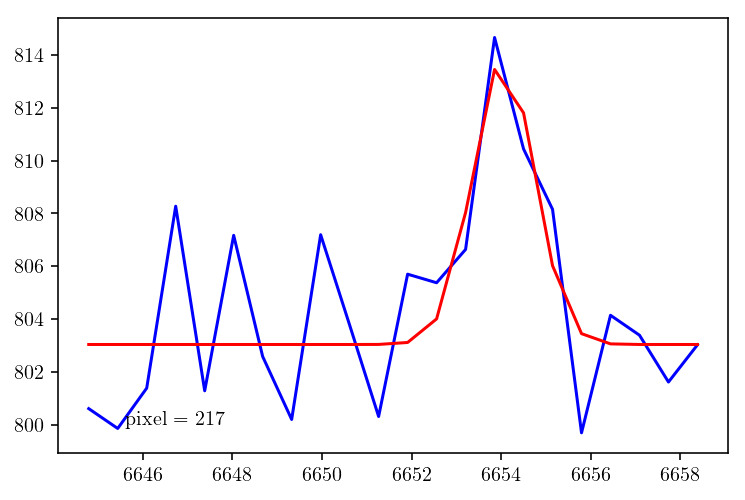

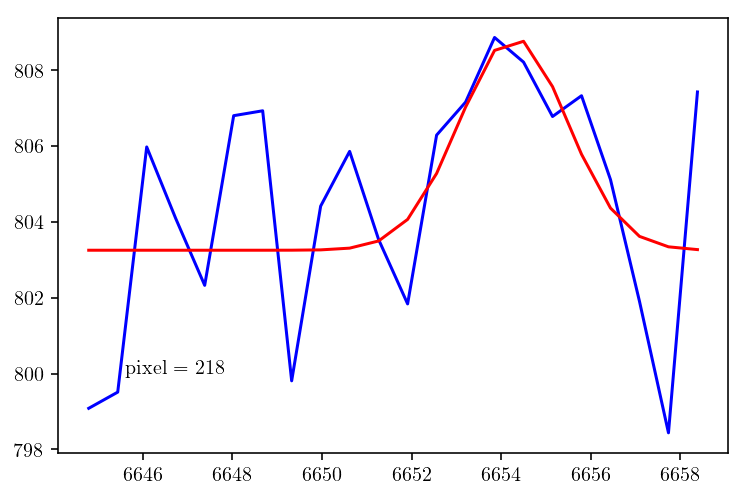

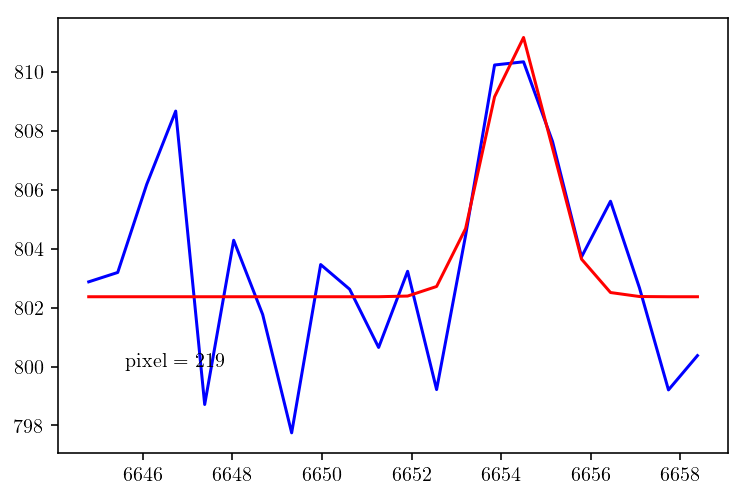

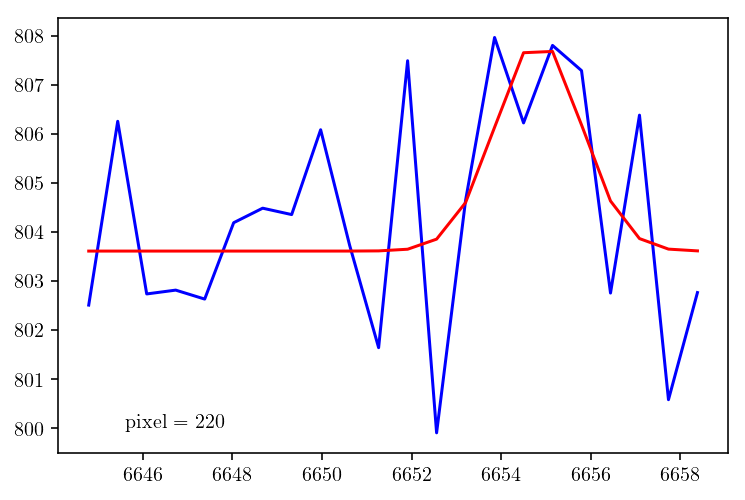

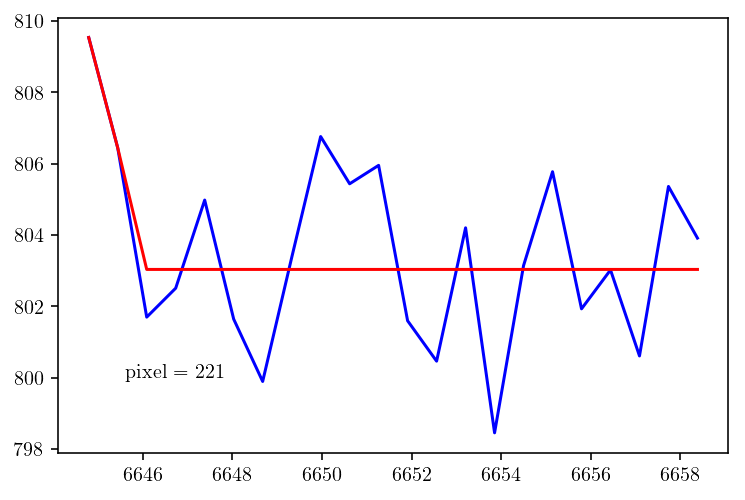

Fit not achieved for pixel 222
Fit not achieved for pixel 223


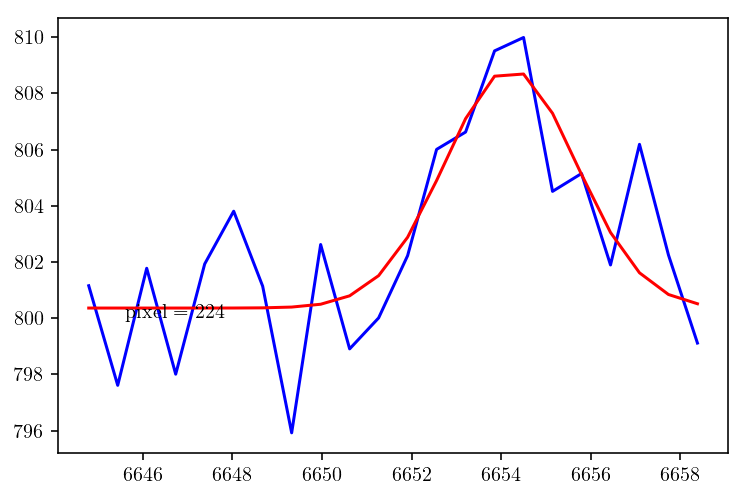

Fit not achieved for pixel 225


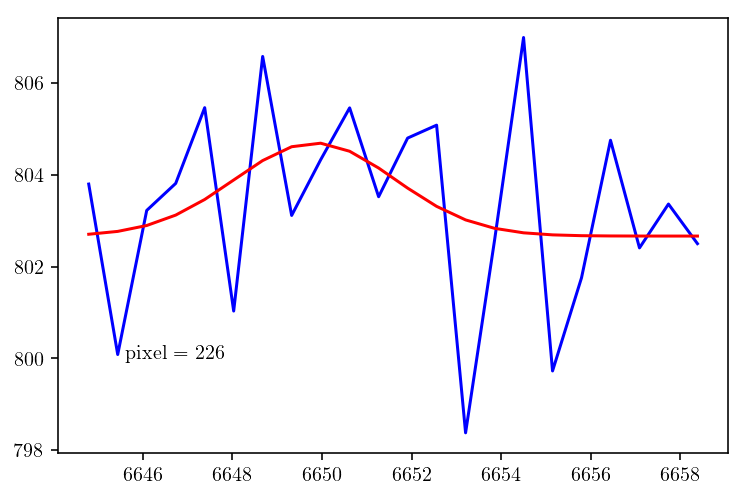

In [52]:
# These chosen through trial and error/using DS9
good_pixels_start = 95
good_pixels_end   = 227

# Fit for centroids
centroids = fit_centroids(wl_zoomed, ugc11876_zoomed, good_pixels_start, good_pixels_end, show_plot=True)

#### Note bad fits at pixels:
    - 137
    - 142
    - 221
#### Data is too noisy at pixels:
    - 214
    - 226

In [56]:
# Save the centroids after inspecting them
np.save('centroids_golay_filter.npy', centroids)

In [73]:
# Remove the bad fits and save
centroids_cleaned = np.copy(centroids)
bad_pixels = [137, 142, 214, 221, 226]
for bad_pix in bad_pixels:
    bad_row_ind = np.argwhere(centroids_cleaned[:, 1] == bad_pix)[0][0]
    centroids_cleaned = np.delete(centroids_cleaned, bad_row_ind, axis=0)
print("Removed {} bad rows. Now have a total of {} rows.".format(centroids.shape[0]-centroids_cleaned.shape[0], 
                                                                 centroids_cleaned.shape[0]))

Removed 5 bad rows. Now have a total of 124 rows.


In [74]:
# Save
np.save('centroids_golay_filter_cleaned.npy', centroids_cleaned)

## With the centroid vs pixel data, we can now calculate the rotation curve

In [10]:
# centroids_cleaned = np.load('centroids_golay_filter.npy')
# print(centroids_cleaned)

[[6648.94055903   95.        ]
 [6649.27363598   96.        ]
 [6648.88755691   97.        ]
 [6649.00244255   98.        ]
 [6648.89830122   99.        ]
 [6649.01171736  100.        ]
 [6648.90470203  101.        ]
 [6648.99815704  102.        ]
 [6649.12173396  103.        ]
 [6649.11327768  104.        ]
 [6649.22685046  105.        ]
 [6649.408676    106.        ]
 [6649.46518615  107.        ]
 [6649.6454031   108.        ]
 [6649.26268744  109.        ]
 [6649.47713833  110.        ]
 [6649.56384349  111.        ]
 [6649.56515204  112.        ]
 [6649.7807831   113.        ]
 [6649.48255413  114.        ]
 [6649.54499063  115.        ]
 [6649.60593262  116.        ]
 [6649.72023183  117.        ]
 [6649.3103887   118.        ]
 [6649.24801132  119.        ]
 [6649.28797936  120.        ]
 [6649.24035444  121.        ]
 [6649.34794678  122.        ]
 [6649.31048941  123.        ]
 [6649.48177775  124.        ]
 [6649.62743809  125.        ]
 [6649.52152418  126.        ]
 [6649.7

In [9]:
# halpha_obs = np.mean(centroids_cleaned[:, 0]) # Angstroms
# redshift_ugc11876 = calc_redshift(halpha_obs, H_ALPHA_REST)
# print(halpha_obs)
# print(redshift_ugc11876)

6651.773769545537
0.013557287978536132


In [76]:
# Calculate redshift of galaxy
halpha_obs = np.mean(centroids_cleaned[:, 0]) # Angstroms
redshift_ugc11876 = calc_redshift(halpha_obs, H_ALPHA_REST)

# Calculate velocity
velocity_ugc11876 = calc_velocity(redshift_ugc11876) # km/s

# Calculate distance
d = calc_distance(velocity_ugc11876) # Mpc

In [77]:
# Estimate the central pixel
center_pix = np.mean(centroids_cleaned[:, 1])

In [78]:
# Calculate the raidus and velocity curve
pixel_r = np.abs(centroids_cleaned[:, 1] - center_pix)
radius  = 1e3 * (np.tan(KAST_RED_PS * (2 * np.pi / 360 / 3600) * pixel_r) * d) # Kpc
velocity = np.abs(calc_velocity(calc_redshift(centroids_cleaned[:, 0], halpha_obs)))   # km/s

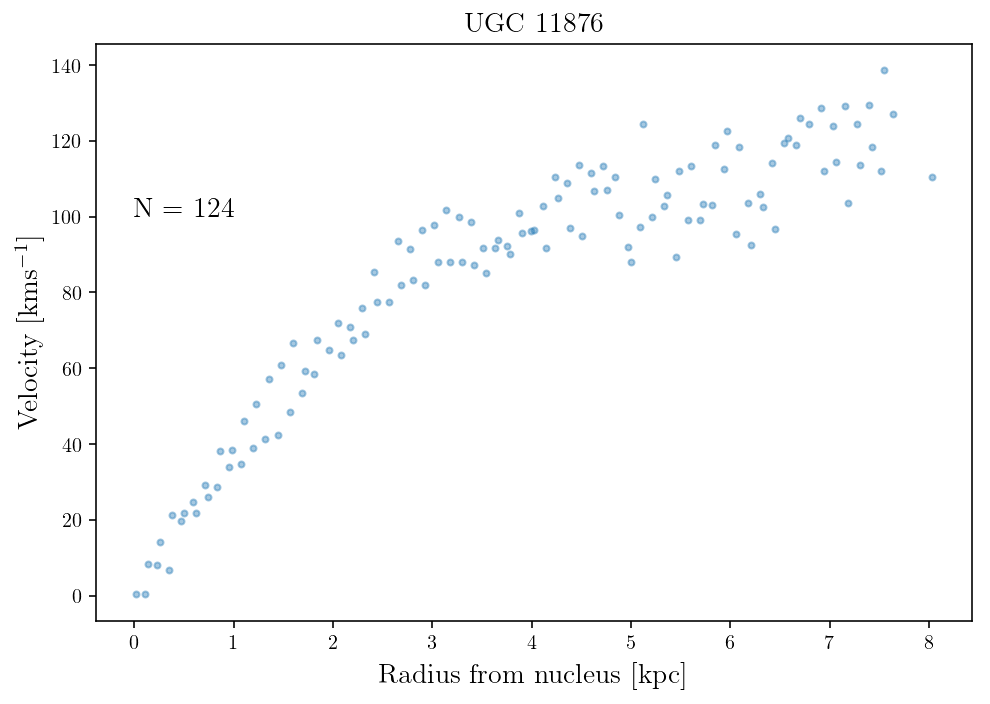

In [80]:
fig, ax = plt.subplots(figsize=(7,5))

ax.text(0, 100, 'N = {}'.format(len(velocity)), fontsize=14)

ax.plot(radius, velocity, '.', alpha=0.4)

ax.set_xlabel('Radius from nucleus [kpc]', fontsize=14)
ax.set_ylabel(r'Velocity [kms$^{-1}$]', fontsize=14)
ax.set_title('UGC 11876', fontsize=14)

fig.tight_layout()
fig.savefig(os.path.join(data_folder, 'ugc11876_rotation_curve.pdf'))

plt.show()